# Análise com o resultado do rating


In [2]:
import os
import dotenv

import boto3
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from matplotlib import pyplot as plt

import pickle
import shutil

import locale

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
modelsPath = os.path.join(rootPath, 'models')
env = os.path.join(rootPath, '.env')
dotenv.load_dotenv(dotenv_path=env)

True

In [5]:
import locale

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

# 01) Importando dados

In [6]:
s3 = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=os.getenv("AWS_ACESS_KEY"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACESS_KEY")
    )

def read_s3(bucket_name, folder_name, file_name):
    file_key_aws = folder_name + file_name
    obj = s3.Bucket(bucket_name).Object(file_key_aws).get()
    df = pd.read_csv(obj['Body'], sep=';')
    return df

# QUERY VERSÃO 1 - ANÁLISES

In [44]:
tbl_debitos_dam = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_dam.csv'
debitos_divida = pd.read_csv(tbl_debitos_dam)
debitos_divida

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [7]:
dd = debitos_divida[debitos_divida['ano_fato_gerador'] == 2016]
dd

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
4,000032f6d93a0abd,b8cf2b607f401535eeaa6b163b2f9024,71fc88ab6bbb201c344d77602867ec09,2016.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,1946.50,0.00,1852.10
13,00006a4fa855b308,f02cff9218e0fb81eeaa6b163b2f9024,d87e514082d2101ed4613fe022d53698,2016.0,1.0,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,1,0,1,212.80,0.00,175.04
17,0000a2cbd951c1ca,35d7656f6131adc4eeaa6b163b2f9024,c2357fdb65f5cbed8e79cf1867e8cc19,2016.0,1.0,174.01,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 21:52:00,1,0,1,2356.70,0.00,2262.30
27,0000c599ab737fa1,720bdd5593728933eeaa6b163b2f9024,4c375f5fe6f11e99cd124eb8021f7dca,2016.0,1.0,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,1,0,1,880.90,0.00,786.50
45,0000fe7e1c1dbbe4,620a1ce8ee04f3f5eeaa6b163b2f9024,ec4080f1474d5e63d4613fe022d53698,2016.0,1.0,81.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VISTA,2008-12-11 16:41:41,1,0,1,644.80,0.00,550.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205229,NaN,fffa93f915d816bceeaa6b163b2f9024,NaN,2016.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1,0.00,416.46,416.46
4205269,NaN,fffc83d7044e921e2b46f673bf0c6125,NaN,2016.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,91.31,0.00,89.99
4205288,NaN,fffd2265594cf0d14c1f696350fff79e,NaN,2016.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1,0.00,3045.58,3045.58
4205298,NaN,fffd432719007e13eeaa6b163b2f9024,NaN,2016.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,344.17,0.00,339.45


---

In [43]:
formatar_moeda(debitos_divida['vlr_total_dam'].sum())

'R$ 6.990.079.245,86'

In [72]:
soma_por_ano = debitos_divida.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano


,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1976.0,"R$ 0,00","R$ 861,68","R$ 0,00","R$ 861,68"
1,1980.0,"R$ 578,18","R$ 1.578,18","R$ 0,00","R$ 1.000,00"
2,1981.0,"R$ 613,62","R$ 1.533,08","R$ 0,00","R$ 919,46"
3,1982.0,"R$ 608,45","R$ 1.500,52","R$ 0,00","R$ 892,07"
4,1983.0,"R$ 557,99","R$ 550,39","R$ 0,00","R$ -7,60"
5,1984.0,"R$ 532,04","R$ 3.105,17","R$ 0,00","R$ 2.573,13"
6,1985.0,"R$ 1.268,00","R$ 26.610,98","R$ 5.199,77","R$ 25.342,98"
7,1986.0,"R$ 0,00","R$ 44.353,28","R$ 4.388,06","R$ 44.353,28"
8,1987.0,"R$ 840.101,23","R$ 12.774.627,76","R$ 10.519.773,81","R$ 11.934.526,53"
9,1988.0,"R$ 25.766,99","R$ 1.888.276,47","R$ 1.801.321,30","R$ 1.862.509,48"


In [47]:
dams_pagas = debitos_divida[(debitos_divida['vlr_pago'] == debitos_divida['vlr_total_dam'])]
dams_pagas

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,2944.10,0.0,2944.10
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,2627.70,0.0,2627.70
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,3335.10,0.0,3335.10
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,3630.40,0.0,3630.40
5,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,2459.37,0.0,2459.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205358,NaN,ffffcfdcdefb134411babe4a46e18b6d,NaN,2018.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,354.90,0.0,354.90
4205359,NaN,ffffd1829c50006711babe4a46e18b6d,NaN,2018.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,555.53,0.0,555.53
4205361,NaN,ffffd81294e264fe0ba9f03948490762,NaN,2020.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,435.19,0.0,435.19
4205362,NaN,ffffdf41159b669d4c1f696350fff79e,NaN,2019.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,278.34,0.0,278.34


# ARRECADADO POR ANO

In [62]:
soma_por_ano = dams_pagas.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'

}).reset_index()

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)

soma_por_ano


,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto
0,1985.0,"R$ 937,24","R$ 937,24","R$ 0,00"
1,1987.0,"R$ 61.718,31","R$ 61.718,31","R$ 0,00"
2,1988.0,"R$ 0,00","R$ 0,00","R$ 0,00"
3,1989.0,"R$ 0,00","R$ 0,00","R$ 0,00"
4,1990.0,"R$ 49.851,72","R$ 49.851,72","R$ 0,00"
5,1991.0,"R$ 3.151,84","R$ 3.151,84","R$ 0,00"
6,1992.0,"R$ 5.932,59","R$ 5.932,59","R$ 0,00"
7,1993.0,"R$ 199.570,84","R$ 199.570,84","R$ 0,00"
8,1994.0,"R$ 33.166,36","R$ 33.166,36","R$ 0,00"
9,1995.0,"R$ 3.338,16","R$ 3.338,16","R$ 0,00"


In [52]:
formatar_moeda(dams_pagas['vlr_total_dam'].sum())

'R$ 3.758.008.160,98'

In [48]:
dams_não_pagas = debitos_divida[(debitos_divida['vlr_pago'] == 0)]
dams_não_pagas

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
15,00006a4fa855b308,fd695ecd2d8cc7762fdf6d5f8117540c,d87e514082d2101ed4613fe022d53698,2013.0,1.0,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,0,1,1,0.0,198.15,198.15
26,0000c599ab737fa1,52a09679bbf7a68690ecf5aaf6be6eb7,4c375f5fe6f11e99cd124eb8021f7dca,2023.0,1.0,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,0,1,1,0.0,1548.54,1548.54
35,0000d8e55e83b975,4afaf6c7173e4197875350beaddc7871,62067d8c0d1754a5ec24828071529570,2022.0,1.0,144.62,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2017-01-04 16:10:45,0,1,1,0.0,4075.82,4075.82
36,0000d8e55e83b975,85ebc70094dc08ab90ecf5aaf6be6eb7,62067d8c0d1754a5ec24828071529570,2023.0,1.0,144.62,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2017-01-04 16:10:45,0,1,1,0.0,3564.72,3564.72
38,0000e13a7d8d7537,5e6259444ed23a59875350beaddc7871,NaN,2022.0,1.0,61.20,1,P,CASA,CONSTRUÍDA,SAN MARTIN,2008-12-11 19:44:26,0,1,1,0.0,601.44,601.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205360,NaN,ffffd62be294c472875350beaddc7871,NaN,2022.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1,0.0,463.85,463.85
4205363,NaN,ffffdf41159b669d875350beaddc7871,NaN,2022.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,1,0.0,0.00,159.72
4205365,NaN,ffffe50b8579275e90ecf5aaf6be6eb7,NaN,2023.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1,0.0,137.56,137.56
4205367,NaN,ffffe774bca33c4619002eec9f619408,NaN,2021.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1,0.0,442.85,442.85


In [70]:
soma_por_ano = dams_não_pagas.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano


,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1976.0,"R$ 0,00","R$ 861,68","R$ 0,00","R$ 861,68"
1,1980.0,"R$ 0,00","R$ 1.007,60","R$ 0,00","R$ 1.007,60"
2,1981.0,"R$ 0,00","R$ 927,06","R$ 0,00","R$ 927,06"
3,1982.0,"R$ 0,00","R$ 899,67","R$ 0,00","R$ 899,67"
4,1984.0,"R$ 0,00","R$ 2.580,73","R$ 0,00","R$ 2.580,73"
5,1985.0,"R$ 0,00","R$ 24.889,19","R$ 5.199,77","R$ 24.889,19"
6,1986.0,"R$ 0,00","R$ 44.353,28","R$ 4.388,06","R$ 44.353,28"
7,1987.0,"R$ 0,00","R$ 11.937.116,44","R$ 10.519.773,81","R$ 11.937.116,44"
8,1988.0,"R$ 0,00","R$ 1.859.367,05","R$ 1.798.016,68","R$ 1.859.367,05"
9,1989.0,"R$ 0,00","R$ 1.055.663.189,89","R$ 1.055.537.630,63","R$ 1.055.663.189,89"


In [66]:
dams_pagas_parcialmente = debitos_divida[(debitos_divida['vlr_pago'] > 0) & (debitos_divida['vlr_pago'] < debitos_divida['vlr_total_dam'])]
dams_pagas_parcialmente

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
9,00006a4fa855b308,5e47335403663289e08920064611a7cf,d87e514082d2101ed4613fe022d53698,2017.0,1.0,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,1,0,1,252.53,0.00,292.30
18,0000a2cbd951c1ca,435620f76ae803e219002eec9f619408,c2357fdb65f5cbed8e79cf1867e8cc19,2021.0,1.0,174.01,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 21:52:00,1,0,1,2636.40,0.00,2646.25
19,0000a2cbd951c1ca,621779c21ab522df875350beaddc7871,c2357fdb65f5cbed8e79cf1867e8cc19,2022.0,1.0,174.01,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 21:52:00,1,0,1,3713.31,0.00,3780.80
23,0000a2cbd951c1ca,d3616069bbb7c23b90ecf5aaf6be6eb7,c2357fdb65f5cbed8e79cf1867e8cc19,2023.0,1.0,174.01,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 21:52:00,1,1,1,3075.36,814.94,3890.30
32,0000d8e55e83b975,1c12b3fbd8a766c24c1f696350fff79e,62067d8c0d1754a5ec24828071529570,2019.0,1.0,144.62,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2017-01-04 16:10:45,1,0,1,3129.69,0.00,3720.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4201724,NaN,ff774fa587c33cc26c624eea554ca8d2,NaN,2003.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,1,1,1297.46,1732.64,3030.10
4203117,NaN,fface1fdd0869c732ae93ff99c4000e8,NaN,1992.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,779.08,0.00,1094.88
4203499,NaN,ffba0e56c0c9879689ee41b44b65fb05,NaN,2005.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,1,1,26929.53,888.95,27818.48
4203652,NaN,ffbf6c5dc50645312b0ed56c63dc92b2,NaN,1997.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,1,1,1837.18,158.23,1995.41


In [69]:
soma_por_ano = dams_pagas_parcialmente.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

# Criando a nova coluna 'suposto_valor_devido'
soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

# Formatando as colunas 'vlr_total_dam', 'vlr_pago' e 'vlr_aberto' como moeda
soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano


,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1985.0,"R$ 330,76","R$ 784,55","R$ 0,00","R$ 453,79"
1,1988.0,"R$ 1.936,84","R$ 5.233,97","R$ 3.304,62","R$ 3.297,13"
2,1989.0,"R$ 850,69","R$ 2.638,45","R$ 1.791,16","R$ 1.787,76"
3,1990.0,"R$ 33.603.622,63","R$ 41.214.779,36","R$ 0,00","R$ 7.611.156,73"
4,1991.0,"R$ 5.828.486,28","R$ 6.708.086,08","R$ 0,00","R$ 879.599,80"
5,1992.0,"R$ 76.027.065,18","R$ 84.163.019,07","R$ 927,36","R$ 8.135.953,89"
6,1993.0,"R$ 9.434.104,36","R$ 9.859.874,38","R$ 1.879,34","R$ 425.770,02"
7,1994.0,"R$ 3.791.035,23","R$ 3.997.097,64","R$ 120,39","R$ 206.062,41"
8,1995.0,"R$ 762.617,55","R$ 813.702,57","R$ 68,75","R$ 51.085,02"
9,1996.0,"R$ 81.489,51","R$ 212.210,36","R$ 4.059,02","R$ 130.720,85"


In [50]:
dams_pagas_superior_a_divida = debitos_divida[(debitos_divida['vlr_pago'] > debitos_divida['vlr_total_dam'])]
dams_pagas_superior_a_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
4,000032f6d93a0abd,b8cf2b607f401535eeaa6b163b2f9024,71fc88ab6bbb201c344d77602867ec09,2016.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,1946.50,0.0,1852.10
13,00006a4fa855b308,f02cff9218e0fb81eeaa6b163b2f9024,d87e514082d2101ed4613fe022d53698,2016.0,1.0,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,1,0,1,212.80,0.0,175.04
17,0000a2cbd951c1ca,35d7656f6131adc4eeaa6b163b2f9024,c2357fdb65f5cbed8e79cf1867e8cc19,2016.0,1.0,174.01,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 21:52:00,1,0,1,2356.70,0.0,2262.30
27,0000c599ab737fa1,720bdd5593728933eeaa6b163b2f9024,4c375f5fe6f11e99cd124eb8021f7dca,2016.0,1.0,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,1,0,1,880.90,0.0,786.50
45,0000fe7e1c1dbbe4,620a1ce8ee04f3f5eeaa6b163b2f9024,ec4080f1474d5e63d4613fe022d53698,2016.0,1.0,81.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VISTA,2008-12-11 16:41:41,1,0,1,644.80,0.0,550.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205327,NaN,fffe77bd77c1ab46f4df934698e31658,NaN,2006.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,185.40,0.0,182.71
4205340,NaN,ffff29c6afbd6f7f3d648baf21387e6f,NaN,2014.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,412.28,0.0,407.99
4205349,NaN,ffff9c9f7e78fa7be67cda4bf42b9b53,NaN,2015.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,295.72,0.0,291.43
4205351,NaN,ffffa95ab3cedab8eeaa6b163b2f9024,NaN,2016.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,707.84,0.0,693.68


In [71]:
soma_por_ano = dams_pagas_superior_a_divida.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

# Criando a nova coluna 'suposto_valor_devido'
soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

# Formatando as colunas 'vlr_total_dam', 'vlr_pago' e 'vlr_aberto' como moeda
soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1980.0,"R$ 578,18","R$ 570,58","R$ 0,00","R$ -7,60"
1,1981.0,"R$ 613,62","R$ 606,02","R$ 0,00","R$ -7,60"
2,1982.0,"R$ 608,45","R$ 600,85","R$ 0,00","R$ -7,60"
3,1983.0,"R$ 557,99","R$ 550,39","R$ 0,00","R$ -7,60"
4,1984.0,"R$ 532,04","R$ 524,44","R$ 0,00","R$ -7,60"
5,1987.0,"R$ 778.382,92","R$ 775.793,01","R$ 0,00","R$ -2.589,91"
6,1988.0,"R$ 23.830,15","R$ 23.675,45","R$ 0,00","R$ -154,70"
7,1989.0,"R$ 2.560.443,28","R$ 2.552.410,82","R$ 0,00","R$ -8.032,46"
8,1990.0,"R$ 56.475.335,71","R$ 55.458.019,10","R$ 0,00","R$ -1.017.316,61"
9,1991.0,"R$ 406.564,34","R$ 395.687,98","R$ 0,00","R$ -10.876,36"


In [35]:
nulos = debitos_divida[(pd.notnull(debitos_divida['dam'])) & (pd.isnull(debitos_divida['id_contribuinte']))]
nulos = nulos['dam'].count()
nulos


1846767

In [36]:
1846767/4205369


0.43914505480969684

In [ ]:
contagem_nulos_por_coluna = debitos_divida.isnull().sum()
contagem_nulos_por_coluna.to_frame()


In [37]:
contagem_nulos_por_coluna = debitos_divida.isnull().sum()
total_registros = len(debitos_divida)

porcentagem_nulos_por_coluna = (contagem_nulos_por_coluna / total_registros) * 100

resultado = pd.DataFrame({
    'Sem Registro': contagem_nulos_por_coluna,
    'Total Registros': total_registros,
    'Porcentagem Nulos (%)': porcentagem_nulos_por_coluna
})

resultado


,Sem Registro,Total Registros,Porcentagem Nulos (%)
id_imovel,1698842,4205369,40.396978
dam,0,4205369,0.000000
id_contribuinte,1846767,4205369,43.914505
ano_fato_gerador,0,4205369,0.000000
qtd_pavimentos,1698842,4205369,40.396978
area_construida,1806907,4205369,42.966670
imovel_regular,0,4205369,0.000000
natureza_imovel,1698842,4205369,40.396978
tipo_propriedade,1806907,4205369,42.966670
situacao_edificacao,1806907,4205369,42.966670


In [30]:
1846767/4205369

0.43914505480969684

In [10]:
aux = debitos_divida[(debitos_divida['vlr_pago']) > (debitos_divida['vlr_total_dam'])]
aux

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
4,000032f6d93a0abd,b8cf2b607f401535eeaa6b163b2f9024,71fc88ab6bbb201c344d77602867ec09,2016.0,1.0,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,1,0,1,1946.50,0.0,1852.10
13,00006a4fa855b308,f02cff9218e0fb81eeaa6b163b2f9024,d87e514082d2101ed4613fe022d53698,2016.0,1.0,48.85,1,P,APARTAMENTO,CONSTRUÍDA,IPUTINGA,2008-12-11 22:40:00,1,0,1,212.80,0.0,175.04
17,0000a2cbd951c1ca,35d7656f6131adc4eeaa6b163b2f9024,c2357fdb65f5cbed8e79cf1867e8cc19,2016.0,1.0,174.01,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 21:52:00,1,0,1,2356.70,0.0,2262.30
27,0000c599ab737fa1,720bdd5593728933eeaa6b163b2f9024,4c375f5fe6f11e99cd124eb8021f7dca,2016.0,1.0,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,1,0,1,880.90,0.0,786.50
45,0000fe7e1c1dbbe4,620a1ce8ee04f3f5eeaa6b163b2f9024,ec4080f1474d5e63d4613fe022d53698,2016.0,1.0,81.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VISTA,2008-12-11 16:41:41,1,0,1,644.80,0.0,550.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205327,NaN,fffe77bd77c1ab46f4df934698e31658,NaN,2006.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,185.40,0.0,182.71
4205340,NaN,ffff29c6afbd6f7f3d648baf21387e6f,NaN,2014.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,412.28,0.0,407.99
4205349,NaN,ffff9c9f7e78fa7be67cda4bf42b9b53,NaN,2015.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,295.72,0.0,291.43
4205351,NaN,ffffa95ab3cedab8eeaa6b163b2f9024,NaN,2016.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,1,707.84,0.0,693.68


In [12]:
pago = formatar_moeda(aux['vlr_pago'].sum())
pago

'R$ 6.094.100.679,25'

In [13]:
devido = formatar_moeda(aux['vlr_total_dam'].sum())
devido

'R$ 6.022.166.056,73'

In [17]:
6094100679.25-6022166056.73

71934622.52000046

In [38]:
df = debitos_divida[debitos_divida['id_contribuinte'] == 'e07ae583135dea50be91dcec7d89e48e']
df

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,qtd_dams_pagas,qtd_dams_abertas,qtd_dams,vlr_pago,vlr_aberto,vlr_total_dam
2425789,f7d1389bd0abda28,0632ea8731b55ff5e67cda4bf42b9b53,e07ae583135dea50be91dcec7d89e48e,2015.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,1,1,1,224.3,269.11,458.23
2425790,f7d1389bd0abda28,20d8380967737de490ecf5aaf6be6eb7,e07ae583135dea50be91dcec7d89e48e,2023.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,0,1,1,0.0,677.79,677.79
2425791,f7d1389bd0abda28,4ae6de3dd567102b11babe4a46e18b6d,e07ae583135dea50be91dcec7d89e48e,2018.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,0,1,1,0.0,577.72,577.72
2425792,f7d1389bd0abda28,567292ce8b5f6b73e08920064611a7cf,e07ae583135dea50be91dcec7d89e48e,2017.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,0,1,1,0.0,519.09,519.09
2425793,f7d1389bd0abda28,6fd07ae9cfe9be844c1f696350fff79e,e07ae583135dea50be91dcec7d89e48e,2019.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,0,1,1,0.0,579.84,579.84
2425794,f7d1389bd0abda28,7336064b99239ba9875350beaddc7871,e07ae583135dea50be91dcec7d89e48e,2022.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,0,1,1,0.0,764.80,764.80
2425795,f7d1389bd0abda28,bb368d341253cf98eeaa6b163b2f9024,e07ae583135dea50be91dcec7d89e48e,2016.0,1.0,45.02,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2010-07-27 11:47:22,0,1,1,0.0,467.28,467.28


# CONTRIBUINTE

In [8]:
tbl_contribuinte = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_contribuinte_debito.csv'
contribuinte = pd.read_csv(tbl_contribuinte)
contribuinte

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica
0,e25f07f4638b0b4f344d77602867ec09,2.0,5.0,NaN,1.0,1,NaN
1,eaf4d42d27e17f6e344d77602867ec09,1.0,NaN,NaN,5.0,1,NaN
2,468eb21a43b1bc8e26c4027692f32824,NaN,NaN,1.0,1.0,1,NaN
3,2fce5f00c6de8bb9cd124eb8021f7dca,8.0,33.0,23.0,41.0,17,2.0
4,e07ae583135dea50be91dcec7d89e48e,2.0,1.0,NaN,1.0,1,NaN
...,...,...,...,...,...,...,...
250260,184ce4bb8e1388d2d8b209292c0ce31d,3.0,1.0,7.0,13.0,5,NaN
250261,6f99d715fd3a90861603ecd7ff6be21f,NaN,NaN,NaN,NaN,1,1.0
250262,7cbdd82cba0c7f3b2da5e2e6f6bac27b,1.0,5.0,NaN,1.0,1,NaN
250263,c66f22bdb84e053a76beb59f44c20df3,2.0,8.0,NaN,1.0,1,NaN


In [45]:
cota = contribuinte[(pd.notnull(contribuinte['freq_parcelamento'])) & (pd.notnull(contribuinte['pgt_cota_unica']))]
# cota = cota['id_contribuinte'].count()
cota

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica
3,2fce5f00c6de8bb9cd124eb8021f7dca,8.0,33.0,23.0,41.0,17,2.0
19,1f20cc92d28aa9e5d8b209292c0ce31d,NaN,NaN,1.0,2.0,1,1.0
67,3b5a76409f3031400246e2b93c1bf25c,NaN,2.0,1.0,2.0,1,1.0
97,54cea081ed640235344d77602867ec09,NaN,NaN,1.0,1.0,1,1.0
115,1ffd55944ff5024d016a94d4634387ac,NaN,2.0,2.0,5.0,2,2.0
...,...,...,...,...,...,...,...
250207,3871511348d7db6f75234379af146d63,NaN,NaN,1.0,NaN,2,1.0
250212,d478d08218d89a2bacc7ff10b872fdd2,1.0,NaN,1.0,4.0,2,1.0
250226,71d5a5f8e6ab9eeb0246e2b93c1bf25c,NaN,NaN,1.0,4.0,1,1.0
250250,7fbdb48b2d7559c39daa7b7dbb545c1c,NaN,7.0,1.0,1.0,1,1.0


In [46]:
12341/250265

0.04931172956665934

In [40]:
aux2 = contribuinte[(contribuinte['reco_divida_ativa']) > (contribuinte['reco_debito'])]
aux2

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica
0,e25f07f4638b0b4f344d77602867ec09,2.0,5.0,NaN,1.0,1,NaN
3,2fce5f00c6de8bb9cd124eb8021f7dca,8.0,33.0,23.0,41.0,17,2.0
5,66b905e3134f4ca98e79cf1867e8cc19,2.0,16.0,NaN,NaN,2,NaN
6,ed595c8ee93307839daa7b7dbb545c1c,4.0,15.0,NaN,4.0,5,3.0
11,f62000e8ac6b4b1575234379af146d63,2.0,6.0,NaN,3.0,1,NaN
...,...,...,...,...,...,...,...
250252,ddbb1cbcd73cf7db9daa7b7dbb545c1c,2.0,4.0,1.0,3.0,1,NaN
250254,870832bef7f7ec6ed8b209292c0ce31d,2.0,8.0,NaN,NaN,2,NaN
250259,30e5330bdb4c664bacc7ff10b872fdd2,1.0,9.0,NaN,7.0,1,NaN
250262,7cbdd82cba0c7f3b2da5e2e6f6bac27b,1.0,5.0,NaN,1.0,1,NaN


In [41]:
67948/250265

0.27150420554212534

In [39]:
df = contribuinte[contribuinte['id_contribuinte'] == 'e07ae583135dea50be91dcec7d89e48e']
df

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica
4,e07ae583135dea50be91dcec7d89e48e,2.0,1.0,NaN,1.0,1,NaN


In [34]:
contagem_nulos_por_coluna_contribuinte = contribuinte.isnull().sum()
total_registros_contribuinte = len(contribuinte)

porcentagem_nulos = (contagem_nulos_por_coluna_contribuinte / total_registros_contribuinte) * 100

resultado = pd.DataFrame({
    'Contagem Nulos': contagem_nulos_por_coluna_contribuinte,
    'Total Registros': total_registros_contribuinte,
    'Porcentagem Nulos (%)': porcentagem_nulos
})

resultado

,Contagem Nulos,Total Registros,Porcentagem Nulos (%)
id_contribuinte,0,250265,0.000000
reco_debito,107813,250265,43.079536
reco_divida_ativa,136310,250265,54.466266
freq_parcelamento,199736,250265,79.809802
hist_pagamento_qtd,95799,250265,38.279024
num_imoveis,0,250265,0.000000
pgt_cota_unica,184845,250265,73.859709


# QUERY VERSÃO 2 - ANÁLISES 14/11

## DAM - DÍVIDAS

In [7]:
tbl_debitos_dam = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_dam_debito_2.csv'
debitos_divida = pd.read_csv(tbl_debitos_dam)
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam
0,fb09bb4434b80ae9,a4ce0d983d87daf30ba9f03948490762,36508256cf126f6afbdc215f5dcc9c51,2020.0,1,58.00,1,P,SALA,CONSTRUÍDA,PAISSANDU,2008-12-11 22:26:39,1080.80,0.00,1080.80
1,cdb6fc0baec18ca9,947726ef6d657fa4875350beaddc7871,c444087f724373939daa7b7dbb545c1c,2022.0,1,110.80,1,P,APARTAMENTO,CONSTRUÍDA,MADALENA,2008-12-11 18:52:27,0.00,2508.44,2508.44
2,d9c9e39c4c4f8ce3,5f6ad6b7a75ce14211babe4a46e18b6d,b340af53f72ff1fdcd124eb8021f7dca,2018.0,1,89.00,1,P,CASA,CONSTRUÍDA,AFOGADOS,2008-12-11 19:54:22,691.70,0.00,691.70
3,870543fc34c438ae,fd6ab9d88cf75642875350beaddc7871,f9004923540036616ffd495caaf8b576,2022.0,1,47.19,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 22:45:44,223.80,0.00,223.80
4,26fe2fe2a920ee0d,d2d0842adc3281e611babe4a46e18b6d,0dedd7fba9ba526dacc7ff10b872fdd2,2018.0,1,69.00,1,P,APARTAMENTO,CONSTRUÍDA,ZUMBI,2008-12-11 22:43:17,359.15,0.00,373.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506522,63b0f5be0c664694,cfc97b6fa2796e3ea7865723b5986f04,570c09175811827b10c0388451f624a3,2004.0,1,78.58,1,P,APARTAMENTO,CONSTRUÍDA,IMBIRIBEIRA,2008-12-11 21:28:12,38.73,0.00,41.54
2506523,98972132de4feb79,770da308146328c34c1f696350fff79e,860a8129e829ca8bd8b209292c0ce31d,2019.0,1,290.04,1,P,APARTAMENTO,CONSTRUÍDA,PARNAMIRIM,2008-12-11 22:38:43,6196.60,0.00,6196.60
2506524,9f8a1cf0054c7611,5e34f216f9dfe909875350beaddc7871,16653db9ca871c86acc7ff10b872fdd2,2022.0,1,75.00,1,P,APARTAMENTO,CONSTRUÍDA,PARNAMIRIM,2008-12-11 18:28:38,2022.90,0.00,2022.90
2506525,5e4191f95bbb9f42,2933303f8a9f9c3f4c1f696350fff79e,57f2d89cb1e4895f75234379af146d63,2019.0,1,12.65,1,P,GARAGEM COMERCIAL,CONSTRUÍDA,PARNAMIRIM,2008-12-11 22:38:20,152.52,0.00,152.52


In [8]:
arq_bairros = r'C:\Users\Consultor\Documents\bases_pesquisa\bairros.xlsx'
tbl_bairros = pd.read_excel(arq_bairros)
tbl_bairros

,bairro,regiao,rpa
0,AFLITOS,NORDESTE,3A
1,AFOGADOS,SUDESTE,5
2,AGUA FRIA,NORTE,2
3,ALTO JOSE BONIFACIO,NORDESTE,3B
4,ALTO JOSE DO PINHO,NORDESTE,3B
...,...,...,...
89,TORROES,OESTE,4
90,TOTO,SUDESTE,5
91,VARZEA,OESTE,4
92,VASCO DA GAMA,NORDESTE,3B


In [9]:
debitos_divida = pd.merge(debitos_divida, tbl_bairros, on='bairro', how='left')
debitos_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
0,fb09bb4434b80ae9,a4ce0d983d87daf30ba9f03948490762,36508256cf126f6afbdc215f5dcc9c51,2020.0,1,58.00,1,P,SALA,CONSTRUÍDA,PAISSANDU,2008-12-11 22:26:39,1080.80,0.00,1080.80,CENTRO,1
1,cdb6fc0baec18ca9,947726ef6d657fa4875350beaddc7871,c444087f724373939daa7b7dbb545c1c,2022.0,1,110.80,1,P,APARTAMENTO,CONSTRUÍDA,MADALENA,2008-12-11 18:52:27,0.00,2508.44,2508.44,OESTE,4
2,d9c9e39c4c4f8ce3,5f6ad6b7a75ce14211babe4a46e18b6d,b340af53f72ff1fdcd124eb8021f7dca,2018.0,1,89.00,1,P,CASA,CONSTRUÍDA,AFOGADOS,2008-12-11 19:54:22,691.70,0.00,691.70,SUDESTE,5
3,870543fc34c438ae,fd6ab9d88cf75642875350beaddc7871,f9004923540036616ffd495caaf8b576,2022.0,1,47.19,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 22:45:44,223.80,0.00,223.80,OESTE,4
4,26fe2fe2a920ee0d,d2d0842adc3281e611babe4a46e18b6d,0dedd7fba9ba526dacc7ff10b872fdd2,2018.0,1,69.00,1,P,APARTAMENTO,CONSTRUÍDA,ZUMBI,2008-12-11 22:43:17,359.15,0.00,373.90,OESTE,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506522,63b0f5be0c664694,cfc97b6fa2796e3ea7865723b5986f04,570c09175811827b10c0388451f624a3,2004.0,1,78.58,1,P,APARTAMENTO,CONSTRUÍDA,IMBIRIBEIRA,2008-12-11 21:28:12,38.73,0.00,41.54,SUL,6
2506523,98972132de4feb79,770da308146328c34c1f696350fff79e,860a8129e829ca8bd8b209292c0ce31d,2019.0,1,290.04,1,P,APARTAMENTO,CONSTRUÍDA,PARNAMIRIM,2008-12-11 22:38:43,6196.60,0.00,6196.60,NORDESTE,3A
2506524,9f8a1cf0054c7611,5e34f216f9dfe909875350beaddc7871,16653db9ca871c86acc7ff10b872fdd2,2022.0,1,75.00,1,P,APARTAMENTO,CONSTRUÍDA,PARNAMIRIM,2008-12-11 18:28:38,2022.90,0.00,2022.90,NORDESTE,3A
2506525,5e4191f95bbb9f42,2933303f8a9f9c3f4c1f696350fff79e,57f2d89cb1e4895f75234379af146d63,2019.0,1,12.65,1,P,GARAGEM COMERCIAL,CONSTRUÍDA,PARNAMIRIM,2008-12-11 22:38:20,152.52,0.00,152.52,NORDESTE,3A


# IMÓVEIS CADASTRADOS POR ANO

In [46]:
contagem_distinta_por_ano = debitos_divida.groupby('ano_fato_gerador')['id_imovel'].nunique().reset_index()
contagem_distinta_por_ano

,ano_fato_gerador,id_imovel
0,1976.0,1
1,1980.0,1
2,1981.0,1
3,1982.0,1
4,1984.0,1
5,1986.0,1
6,1987.0,4
7,1988.0,4
8,1989.0,3
9,1990.0,353


# ANÁLISE DOS CONTRIBUINTES NULOS

In [10]:
check_contribuinte = debitos_divida[debitos_divida['id_contribuinte'].isnull()]
check_contribuinte

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
5,6503bfb9ebc00b58,a1bb4e4d67edf0e711babe4a46e18b6d,NaN,2018.0,1,349.37,1,P,CASA,CONSTRUÍDA,VARZEA,2008-12-11 19:32:57,4094.60,0.0,4094.60,OESTE,4
13,db05e7c703107e4a,138a65dd03fa02de11babe4a46e18b6d,NaN,2018.0,1,44.00,1,P,CASA,CONSTRUÍDA,NOVA DESCOBERTA,2008-12-11 22:33:52,180.32,0.0,180.32,NORDESTE,3B
32,3961340c13802c1e,714af9e1586a4785875350beaddc7871,NaN,2022.0,1,NaN,1,T,NaN,NaN,JIQUIA,2008-12-11 22:48:38,916.30,0.0,916.30,SUDESTE,5
37,1cdb5e4ede1d6b04,3878bd8a56cb98e511babe4a46e18b6d,NaN,2018.0,1,224.00,1,P,CASA,CONSTRUÍDA,BOMBA DO HEMETERIO,2008-12-11 17:26:17,4112.50,0.0,4112.50,NORTE,2
47,1f08b81a395b12a0,87653c3f381d6cf7875350beaddc7871,NaN,2022.0,1,130.00,1,P,HOTEL,CONSTRUÍDA,SAO JOSE,2008-12-11 17:07:33,2933.21,0.0,3052.80,CENTRO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506453,dd243fef4c8fca79,fe5ae23c4112892019002eec9f619408,NaN,2021.0,1,114.39,1,P,APARTAMENTO,CONSTRUÍDA,MADALENA,2008-12-11 22:44:02,1239.40,0.0,1239.40,OESTE,4
2506454,f9ac3214aa7de344,766eea9948ac44bf4c1f696350fff79e,NaN,2019.0,1,165.18,1,P,CASA,CONSTRUÍDA,MANGUEIRA,2008-12-11 22:47:42,952.44,0.0,958.14,SUDESTE,5
2506493,12c707019dcd7ddf,88ae09dc94511eb24c1f696350fff79e,NaN,2019.0,1,118.48,1,P,APARTAMENTO,CONSTRUÍDA,CASA AMARELA,2008-12-11 22:36:32,1236.10,0.0,1452.82,NORDESTE,3A
2506518,b1ff1d4ccf6bb048,0a8dad8d3a0ac7446c624eea554ca8d2,NaN,2003.0,1,NaN,1,T,NaN,NaN,BARRO,2008-12-11 20:29:48,0.00,0.0,17162.31,SUDESTE,5


In [47]:
total_dams_iguais = (check_contribuinte['vlr_pago'] == check_contribuinte['vlr_total_dam']).sum()
total_dams = len(check_contribuinte)
percentual_dams_iguais = (total_dams_iguais / total_dams) * 100

print(f"Quantidade de DAMs em que vlr_pago é igual a vlr_total_dam: {total_dams_iguais}")
print(f"Percentual: {percentual_dams_iguais:.2f}%")

Quantidade de DAMs em que vlr_pago é igual a vlr_total_dam: 50624
Percentual: 34.22%


In [48]:
total_dams_iguais = (check_contribuinte['vlr_pago'] == 0).sum()
total_dams = len(check_contribuinte)
percentual_dams_iguais = (total_dams_iguais / total_dams) * 100

print(f"Quantidade de DAMs em que vlr_pago é igual a zero: {total_dams_iguais}")
print(f"Percentual: {percentual_dams_iguais:.2f}%")

Quantidade de DAMs em que vlr_pago é igual a zero: 76590
Percentual: 51.78%


In [49]:
total_dams_iguais = ((check_contribuinte['vlr_pago'] != 0) & (check_contribuinte['vlr_pago'] < check_contribuinte['vlr_total_dam'])).sum()
total_dams = len(check_contribuinte)
percentual_dams_iguais = (total_dams_iguais / total_dams) * 100

print(f"Quantidade de DAMs em que vlr_pago é maior que zero e menor que o lançado: {total_dams_iguais}")
print(f"Percentual: {percentual_dams_iguais:.2f}%")

Quantidade de DAMs em que vlr_pago é maior que zero e menor que o lançado: 20711
Percentual: 14.00%


---

In [11]:
formatar_moeda(debitos_divida['vlr_aberto'].sum())

'R$ 1.169.042.137,47'

In [12]:
soma_por_ano = debitos_divida.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

# Criando a nova coluna 'suposto_valor_devido'
soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

# Formatando as colunas 'vlr_total_dam', 'vlr_pago' e 'vlr_aberto' como moeda
soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1976.0,"R$ 0,00","R$ 861,68","R$ 0,00","R$ 861,68"
1,1980.0,"R$ 0,00","R$ 1.007,60","R$ 0,00","R$ 1.007,60"
2,1981.0,"R$ 0,00","R$ 927,06","R$ 0,00","R$ 927,06"
3,1982.0,"R$ 0,00","R$ 899,67","R$ 0,00","R$ 899,67"
4,1984.0,"R$ 0,00","R$ 962,31","R$ 0,00","R$ 962,31"
5,1986.0,"R$ 0,00","R$ 2.794,37","R$ 0,00","R$ 2.794,37"
6,1987.0,"R$ 0,00","R$ 4.625,46","R$ 0,00","R$ 4.625,46"
7,1988.0,"R$ 0,00","R$ 4.831,22","R$ 0,00","R$ 4.831,22"
8,1989.0,"R$ 0,00","R$ 9.871,41","R$ 0,00","R$ 9.871,41"
9,1990.0,"R$ 33.615.648,94","R$ 45.594.923,03","R$ 1.731.597,26","R$ 11.979.274,09"


In [125]:
formatar_moeda(debitos_divida['vlr_aberto'].sum())

'R$ 1.169.042.137,47'

In [126]:
formatar_moeda(debitos_divida['vlr_total_dam'].sum())

'R$ 6.990.079.245,86'

In [127]:
formatar_moeda(debitos_divida['vlr_pago'].sum())

'R$ 5.417.009.716,40'

In [13]:
dams_pagas = debitos_divida[(debitos_divida['vlr_pago'] == debitos_divida['vlr_total_dam'])]
dams_pagas

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
0,fb09bb4434b80ae9,a4ce0d983d87daf30ba9f03948490762,36508256cf126f6afbdc215f5dcc9c51,2020.0,1,58.00,1,P,SALA,CONSTRUÍDA,PAISSANDU,2008-12-11 22:26:39,1080.80,0.0,1080.80,CENTRO,1
2,d9c9e39c4c4f8ce3,5f6ad6b7a75ce14211babe4a46e18b6d,b340af53f72ff1fdcd124eb8021f7dca,2018.0,1,89.00,1,P,CASA,CONSTRUÍDA,AFOGADOS,2008-12-11 19:54:22,691.70,0.0,691.70,SUDESTE,5
3,870543fc34c438ae,fd6ab9d88cf75642875350beaddc7871,f9004923540036616ffd495caaf8b576,2022.0,1,47.19,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 22:45:44,223.80,0.0,223.80,OESTE,4
5,6503bfb9ebc00b58,a1bb4e4d67edf0e711babe4a46e18b6d,NaN,2018.0,1,349.37,1,P,CASA,CONSTRUÍDA,VARZEA,2008-12-11 19:32:57,4094.60,0.0,4094.60,OESTE,4
6,fec6840961b3c1e0,9e2eb89f67725751875350beaddc7871,ba891109554f1511d8b209292c0ce31d,2022.0,1,77.98,1,P,APARTAMENTO,CONSTRUÍDA,BOA VISTA,2008-12-11 16:55:50,908.90,0.0,908.90,CENTRO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506519,dd87508955744909,c797ed66da2a0fe74c1f696350fff79e,c36498f9a01be2b552d814da2fe43281,2019.0,1,195.83,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2016-04-11 14:27:12,3838.70,0.0,3838.70,SUL,6
2506520,0a5a66e028d8bde0,80345260ff7a6073d32be49b2265ff26,NaN,2012.0,1,121.47,1,P,APARTAMENTO,CONSTRUÍDA,CAMPO GRANDE,2008-12-11 17:50:42,179.52,0.0,179.52,NORTE,2
2506523,98972132de4feb79,770da308146328c34c1f696350fff79e,860a8129e829ca8bd8b209292c0ce31d,2019.0,1,290.04,1,P,APARTAMENTO,CONSTRUÍDA,PARNAMIRIM,2008-12-11 22:38:43,6196.60,0.0,6196.60,NORDESTE,3A
2506524,9f8a1cf0054c7611,5e34f216f9dfe909875350beaddc7871,16653db9ca871c86acc7ff10b872fdd2,2022.0,1,75.00,1,P,APARTAMENTO,CONSTRUÍDA,PARNAMIRIM,2008-12-11 18:28:38,2022.90,0.0,2022.90,NORDESTE,3A


In [14]:
soma_por_ano = dams_pagas.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'

}).reset_index()

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto
0,1990.0,"R$ 12.026,31","R$ 12.026,31","R$ 0,00"
1,1994.0,"R$ 494.662,53","R$ 494.662,53","R$ 0,00"
2,1995.0,"R$ 267,26","R$ 267,26","R$ 0,00"
3,1996.0,"R$ 4.049,49","R$ 4.049,49","R$ 0,00"
4,1997.0,"R$ 6.586,08","R$ 6.586,08","R$ 0,00"
5,1998.0,"R$ 9.699,59","R$ 9.699,59","R$ 0,00"
6,1999.0,"R$ 4.607,03","R$ 4.607,03","R$ 0,00"
7,2000.0,"R$ 25.373,99","R$ 25.373,99","R$ 0,00"
8,2001.0,"R$ 141.533,93","R$ 141.533,93","R$ 0,00"
9,2002.0,"R$ 16.161,09","R$ 16.161,09","R$ 0,00"


In [15]:
dams_não_pagas = debitos_divida[(debitos_divida['vlr_pago'] == 0)]
dams_não_pagas

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
1,cdb6fc0baec18ca9,947726ef6d657fa4875350beaddc7871,c444087f724373939daa7b7dbb545c1c,2022.0,1,110.80,1,P,APARTAMENTO,CONSTRUÍDA,MADALENA,2008-12-11 18:52:27,0.0,2508.44,2508.44,OESTE,4
8,1104680ccd4612da,a493ca5ae4cc1c23875350beaddc7871,c0a70d3ce84f401d1603ecd7ff6be21f,2022.0,1,58.20,0,P,CASA,CONSTRUÍDA,VARZEA,2013-04-08 10:18:52,0.0,437.22,437.22,OESTE,4
31,1b2de7413021f1cd,03f6b01c2a93e82382743b63d3411fc4,286ce242c77d136bcd124eb8021f7dca,2000.0,1,NaN,1,T,NaN,NaN,IBURA,2008-12-11 20:35:27,0.0,4443.30,4443.30,SUL,6B
53,addbf64d7d35e3a4,61847900c5fd707d875350beaddc7871,def8d26e0443ceb991e796325bc06316,2022.0,1,73.37,1,P,CASA,CONSTRUÍDA,CORDEIRO,2008-12-11 19:04:40,0.0,2370.80,2370.80,OESTE,4
55,492bb9abb8085a22,9034344ee13da727875350beaddc7871,34dbeba05a7085b8112e904585afe88d,2022.0,1,365.87,1,P,CASA,CONSTRUÍDA,IPSEP,2008-12-11 21:05:53,0.0,5934.27,5934.27,SUL,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506499,ced41a4e6e5f31a0,7c9c19a7fd7def2490ecf5aaf6be6eb7,d6be9a7f5b6f0077824df1060a8582ba,2023.0,1,86.21,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2011-12-29 12:36:55,0.0,1932.94,1932.94,SUL,6
2506510,0187778f73ce9f3b,39101f8aa2fbeeac11babe4a46e18b6d,b50f7e5cb17d1e67344d77602867ec09,2018.0,1,396.67,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:04:22,0.0,11296.30,11296.30,SUL,6
2506516,b40e990872010408,ff01016eafdb55c00ba9f03948490762,cdb224c18e0998d89daa7b7dbb545c1c,2020.0,3,276.67,1,P,CASA,CONSTRUÍDA,ALTO JOSE DO PINHO,2008-12-11 22:31:29,0.0,1887.95,1887.95,NORDESTE,3B
2506518,b1ff1d4ccf6bb048,0a8dad8d3a0ac7446c624eea554ca8d2,NaN,2003.0,1,NaN,1,T,NaN,NaN,BARRO,2008-12-11 20:29:48,0.0,0.00,17162.31,SUDESTE,5


In [16]:
soma_por_propriedade_nao_pagas = dams_não_pagas.groupby('tipo_propriedade').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_propriedade_nao_pagas['suposto_valor_devido'] = soma_por_propriedade_nao_pagas['vlr_total_dam'] - soma_por_propriedade_nao_pagas['vlr_pago']
soma_por_propriedade_nao_pagas['percentual_pago_%'] = (soma_por_propriedade_nao_pagas['vlr_pago'] / soma_por_propriedade_nao_pagas['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_propriedade_nao_pagas['percentual_dams_%'] = (soma_por_propriedade_nao_pagas['dam'] / 2506527) *100
soma_por_propriedade_nao_pagas['vlr_total_dam'] = soma_por_propriedade_nao_pagas['vlr_total_dam'].apply(formatar_moeda)
soma_por_propriedade_nao_pagas['vlr_pago'] = soma_por_propriedade_nao_pagas['vlr_pago'].apply(formatar_moeda)
soma_por_propriedade_nao_pagas['vlr_aberto'] = soma_por_propriedade_nao_pagas['vlr_aberto'].apply(formatar_moeda)
soma_por_propriedade_nao_pagas['suposto_valor_devido'] = soma_por_propriedade_nao_pagas['suposto_valor_devido'].apply(formatar_moeda)

soma_por_propriedade_nao_pagas = soma_por_propriedade_nao_pagas.sort_values(by='dam', ascending=False)
soma_por_propriedade_nao_pagas

,tipo_propriedade,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%,percentual_dams_%
1,CASA,130156,"R$ 0,00","R$ 250.381.191,07","R$ 229.207.966,92","R$ 250.381.191,07",0.0,5.192683
0,APARTAMENTO,113268,"R$ 0,00","R$ 232.415.891,68","R$ 229.676.521,99","R$ 232.415.891,68",0.0,4.518922
13,LOJA,17096,"R$ 0,00","R$ 80.524.102,00","R$ 79.274.114,27","R$ 80.524.102,00",0.0,0.682059
17,SALA,13840,"R$ 0,00","R$ 27.517.178,79","R$ 27.346.335,81","R$ 27.517.178,79",0.0,0.552158
4,GALPÃO,4610,"R$ 0,00","R$ 46.285.980,19","R$ 43.562.773,24","R$ 46.285.980,19",0.0,0.183920
3,EDIFICAÇÃO ESPECIAL,3847,"R$ 0,00","R$ 80.550.451,15","R$ 71.321.057,36","R$ 80.550.451,15",0.0,0.153479
6,GARAGEM COMERCIAL,1299,"R$ 0,00","R$ 3.531.881,06","R$ 3.496.825,98","R$ 3.531.881,06",0.0,0.051825
15,MOCAMBO,996,"R$ 0,00","R$ 396.848,48","R$ 341.251,05","R$ 396.848,48",0.0,0.039736
10,INDUSTRIA,575,"R$ 0,00","R$ 19.099.884,52","R$ 18.592.867,01","R$ 19.099.884,52",0.0,0.022940
9,HOTEL,506,"R$ 0,00","R$ 7.604.802,74","R$ 7.303.952,21","R$ 7.604.802,74",0.0,0.020187


In [17]:
# victor_check = dams_não_pagas[(pd.notnull(dams_não_pagas['vlr_total_dam'])) & (dams_não_pagas['vlr_aberto'] == 0)]
# victor_check

victor_check = dams_não_pagas[(dams_não_pagas['vlr_total_dam'] > 0) & (dams_não_pagas['vlr_aberto'] == 0)]
victor_check

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
67,d3af023bb9c7ce69,7df131ce5949364f1c7ba0ec9b15d579,NaN,1998.0,1,198.0,1,P,CASA,CONSTRUÍDA,LINHA DO TIRO,2008-12-11 17:21:58,0.0,0.0,6772.50,NORTE,2
295,eab545fc889111b1,9fe269c599c79b042fdf6d5f8117540c,NaN,2013.0,1,NaN,1,T,NaN,NaN,TEJIPIO,2008-12-11 20:21:15,0.0,0.0,2462.33,SUDESTE,5
454,f6c34b1b230918e1,d1dfaff1c8eb6b044c1f696350fff79e,8f8d2f352efdb55516e1974c2936d3e5,2019.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.0,4758.49,OESTE,4
564,3b51a3a951f98908,621835a16a6dd810a7865723b5986f04,NaN,2004.0,1,NaN,1,T,NaN,NaN,VASCO DA GAMA,2008-12-11 18:07:23,0.0,0.0,1192.24,NORDESTE,3B
688,b3ed0eecbbdb168b,650843c5829f82bcf4df934698e31658,NaN,2006.0,1,NaN,1,T,NaN,NaN,COQUEIRAL,2008-12-11 20:14:32,0.0,0.0,1848.14,SUDESTE,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506285,9fdc91cd70ae0de3,38e7a028292a87480ba9f03948490762,8f8d2f352efdb55516e1974c2936d3e5,2020.0,1,NaN,1,T,NaN,NaN,PINA,2019-01-29 11:23:24,0.0,0.0,1682.78,SUL,6
2506333,aa652f66e2dc3604,871695bfa5c834ae774ee00e7e174286,b92060a50f4a9e2675234379af146d63,1991.0,1,NaN,1,T,NaN,NaN,VARZEA,2003-06-17 01:01:01,0.0,0.0,6161.76,OESTE,4
2506334,ac9096f78351d4c2,0abc8041d59987962fdf6d5f8117540c,NaN,2013.0,1,NaN,1,T,NaN,NaN,FUNDAO,2008-12-11 17:24:57,0.0,0.0,18173.42,NORTE,2
2506354,1cac489355b43b33,249fdc359c77b737b16f45bf0c933afd,8e4effd24b86a288d0b31b2c677cf560,1996.0,1,63.0,1,P,CASA,CONSTRUÍDA,SANTO AMARO,2008-12-11 16:24:37,0.0,0.0,1087.04,CENTRO,1


In [97]:
formatar_moeda(dams_não_pagas['vlr_aberto'].sum())

'R$ 895.365.724,63'

In [98]:
formatar_moeda(dams_não_pagas['vlr_total_dam'].sum())

'R$ 1.229.502.089,72'

In [100]:
1229502089.72/895365724.63

1.3731842261753746

In [18]:
soma_por_ano = dams_não_pagas.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1976.0,"R$ 0,00","R$ 861,68","R$ 0,00","R$ 861,68"
1,1980.0,"R$ 0,00","R$ 1.007,60","R$ 0,00","R$ 1.007,60"
2,1981.0,"R$ 0,00","R$ 927,06","R$ 0,00","R$ 927,06"
3,1982.0,"R$ 0,00","R$ 899,67","R$ 0,00","R$ 899,67"
4,1984.0,"R$ 0,00","R$ 962,31","R$ 0,00","R$ 962,31"
5,1986.0,"R$ 0,00","R$ 2.794,37","R$ 0,00","R$ 2.794,37"
6,1987.0,"R$ 0,00","R$ 4.625,46","R$ 0,00","R$ 4.625,46"
7,1988.0,"R$ 0,00","R$ 4.831,22","R$ 0,00","R$ 4.831,22"
8,1989.0,"R$ 0,00","R$ 9.871,41","R$ 0,00","R$ 9.871,41"
9,1990.0,"R$ 0,00","R$ 4.251.855,95","R$ 1.731.597,26","R$ 4.251.855,95"


In [19]:
dams_pagas_parcialmente = debitos_divida[(debitos_divida['vlr_pago'] > 0) & (debitos_divida['vlr_pago'] < debitos_divida['vlr_total_dam'])]
dams_pagas_parcialmente

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
4,26fe2fe2a920ee0d,d2d0842adc3281e611babe4a46e18b6d,0dedd7fba9ba526dacc7ff10b872fdd2,2018.0,1,69.00,1,P,APARTAMENTO,CONSTRUÍDA,ZUMBI,2008-12-11 22:43:17,359.15,0.00,373.90,OESTE,4
7,80d6391b01890bd1,78546ddc95d5a970875350beaddc7871,17c8b0a9f3f213150246e2b93c1bf25c,2022.0,2,445.24,1,P,CASA,CONSTRUÍDA,PRADO,2008-12-11 22:44:12,618.02,3566.12,4184.14,OESTE,4
11,7972ee883cc96c40,af59680ab5d0bb8c875350beaddc7871,a833c41c11ede4711603ecd7ff6be21f,2022.0,2,280.90,1,P,GALPÃO,CONSTRUÍDA,IMBIRIBEIRA,2008-12-11 20:40:33,7273.06,0.00,7316.42,SUL,6
17,7758393f3f7b85c2,3e9f571fdec8e63c875350beaddc7871,01783f9c7dcfd63f3f9cf15e6b456837,2022.0,1,97.29,1,P,APARTAMENTO,CONSTRUÍDA,TORRE,2013-10-03 12:42:12,1698.94,0.00,1781.42,OESTE,4
19,54bdab00d64205e0,f15045dabb69376611babe4a46e18b6d,79507b99adeffb9c8e79cf1867e8cc19,2018.0,1,101.55,1,P,APARTAMENTO,CONSTRUÍDA,CAMPO GRANDE,2008-12-11 22:32:00,1372.28,0.00,1477.44,NORTE,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506493,12c707019dcd7ddf,88ae09dc94511eb24c1f696350fff79e,NaN,2019.0,1,118.48,1,P,APARTAMENTO,CONSTRUÍDA,CASA AMARELA,2008-12-11 22:36:32,1236.10,0.00,1452.82,NORDESTE,3A
2506514,d1771e749aa7be64,e347b37e1ca2f537eeaa6b163b2f9024,fc27c17ed3b411e91603ecd7ff6be21f,2016.0,1,47.42,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 18:38:07,223.59,0.00,244.60,OESTE,4
2506517,62c83c0a3ae62748,dc3e9d0e009d9ec10ba9f03948490762,766c351d6ed8954a8e79cf1867e8cc19,2020.0,1,93.87,1,P,APARTAMENTO,CONSTRUÍDA,TORRE,2008-12-11 18:45:27,1092.75,0.00,1096.02,OESTE,4
2506522,63b0f5be0c664694,cfc97b6fa2796e3ea7865723b5986f04,570c09175811827b10c0388451f624a3,2004.0,1,78.58,1,P,APARTAMENTO,CONSTRUÍDA,IMBIRIBEIRA,2008-12-11 21:28:12,38.73,0.00,41.54,SUL,6


In [20]:
victor_check_1 = dams_pagas_parcialmente[(dams_pagas_parcialmente['vlr_total_dam'] > 0) & (dams_pagas_parcialmente['vlr_aberto'] == 0)]
victor_check_1

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
4,26fe2fe2a920ee0d,d2d0842adc3281e611babe4a46e18b6d,0dedd7fba9ba526dacc7ff10b872fdd2,2018.0,1,69.00,1,P,APARTAMENTO,CONSTRUÍDA,ZUMBI,2008-12-11 22:43:17,359.15,0.0,373.90,OESTE,4
11,7972ee883cc96c40,af59680ab5d0bb8c875350beaddc7871,a833c41c11ede4711603ecd7ff6be21f,2022.0,2,280.90,1,P,GALPÃO,CONSTRUÍDA,IMBIRIBEIRA,2008-12-11 20:40:33,7273.06,0.0,7316.42,SUL,6
17,7758393f3f7b85c2,3e9f571fdec8e63c875350beaddc7871,01783f9c7dcfd63f3f9cf15e6b456837,2022.0,1,97.29,1,P,APARTAMENTO,CONSTRUÍDA,TORRE,2013-10-03 12:42:12,1698.94,0.0,1781.42,OESTE,4
19,54bdab00d64205e0,f15045dabb69376611babe4a46e18b6d,79507b99adeffb9c8e79cf1867e8cc19,2018.0,1,101.55,1,P,APARTAMENTO,CONSTRUÍDA,CAMPO GRANDE,2008-12-11 22:32:00,1372.28,0.0,1477.44,NORTE,2
21,d0a2a55fad5ade09,be6b543d8ca2df6d11babe4a46e18b6d,9d282c558e6f26b5be91dcec7d89e48e,2018.0,1,111.36,1,P,APARTAMENTO,CONSTRUÍDA,GRACAS,2008-12-11 22:20:50,1113.68,0.0,1130.17,NORDESTE,3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506478,e78b92f13b726b09,090894441196f675875350beaddc7871,9864155a1944610c9daa7b7dbb545c1c,2022.0,1,99.32,1,P,APARTAMENTO,CONSTRUÍDA,PINA,2008-12-11 20:55:53,1592.22,0.0,1639.38,SUL,6
2506493,12c707019dcd7ddf,88ae09dc94511eb24c1f696350fff79e,NaN,2019.0,1,118.48,1,P,APARTAMENTO,CONSTRUÍDA,CASA AMARELA,2008-12-11 22:36:32,1236.10,0.0,1452.82,NORDESTE,3A
2506514,d1771e749aa7be64,e347b37e1ca2f537eeaa6b163b2f9024,fc27c17ed3b411e91603ecd7ff6be21f,2016.0,1,47.42,1,P,APARTAMENTO,CONSTRUÍDA,VARZEA,2008-12-11 18:38:07,223.59,0.0,244.60,OESTE,4
2506517,62c83c0a3ae62748,dc3e9d0e009d9ec10ba9f03948490762,766c351d6ed8954a8e79cf1867e8cc19,2020.0,1,93.87,1,P,APARTAMENTO,CONSTRUÍDA,TORRE,2008-12-11 18:45:27,1092.75,0.0,1096.02,OESTE,4


In [39]:
victor_check_2 = dams_não_pagas[dams_não_pagas['vlr_total_dam'] != dams_não_pagas['vlr_aberto']]
victor_check_2

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
67,d3af023bb9c7ce69,7df131ce5949364f1c7ba0ec9b15d579,NaN,1998.0,1,198.0,1,P,CASA,CONSTRUÍDA,LINHA DO TIRO,2008-12-11 17:21:58,0.0,0.0,6772.50,NORTE,2
295,eab545fc889111b1,9fe269c599c79b042fdf6d5f8117540c,NaN,2013.0,1,NaN,1,T,NaN,NaN,TEJIPIO,2008-12-11 20:21:15,0.0,0.0,2462.33,SUDESTE,5
454,f6c34b1b230918e1,d1dfaff1c8eb6b044c1f696350fff79e,8f8d2f352efdb55516e1974c2936d3e5,2019.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.0,4758.49,OESTE,4
564,3b51a3a951f98908,621835a16a6dd810a7865723b5986f04,NaN,2004.0,1,NaN,1,T,NaN,NaN,VASCO DA GAMA,2008-12-11 18:07:23,0.0,0.0,1192.24,NORDESTE,3B
688,b3ed0eecbbdb168b,650843c5829f82bcf4df934698e31658,NaN,2006.0,1,NaN,1,T,NaN,NaN,COQUEIRAL,2008-12-11 20:14:32,0.0,0.0,1848.14,SUDESTE,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506285,9fdc91cd70ae0de3,38e7a028292a87480ba9f03948490762,8f8d2f352efdb55516e1974c2936d3e5,2020.0,1,NaN,1,T,NaN,NaN,PINA,2019-01-29 11:23:24,0.0,0.0,1682.78,SUL,6
2506333,aa652f66e2dc3604,871695bfa5c834ae774ee00e7e174286,b92060a50f4a9e2675234379af146d63,1991.0,1,NaN,1,T,NaN,NaN,VARZEA,2003-06-17 01:01:01,0.0,0.0,6161.76,OESTE,4
2506334,ac9096f78351d4c2,0abc8041d59987962fdf6d5f8117540c,NaN,2013.0,1,NaN,1,T,NaN,NaN,FUNDAO,2008-12-11 17:24:57,0.0,0.0,18173.42,NORTE,2
2506354,1cac489355b43b33,249fdc359c77b737b16f45bf0c933afd,8e4effd24b86a288d0b31b2c677cf560,1996.0,1,63.0,1,P,CASA,CONSTRUÍDA,SANTO AMARO,2008-12-11 16:24:37,0.0,0.0,1087.04,CENTRO,1


In [24]:
formatar_moeda(dams_pagas_parcialmente['vlr_aberto'].sum())

'R$ 273.676.412,84'

In [14]:
soma_por_ano = dams_pagas_parcialmente.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

# Criando a nova coluna 'suposto_valor_devido'
soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

# Formatando as colunas 'vlr_total_dam', 'vlr_pago' e 'vlr_aberto' como moeda
soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido
0,1990.0,"R$ 33.603.622,63","R$ 41.331.040,77","R$ 0,00","R$ 7.727.418,14"
1,1991.0,"R$ 5.988.740,31","R$ 6.906.027,05","R$ 0,00","R$ 917.286,74"
2,1992.0,"R$ 76.141.590,26","R$ 85.357.544,02","R$ 927,36","R$ 9.215.953,76"
3,1993.0,"R$ 17.330.697,79","R$ 17.878.404,50","R$ 1.879,34","R$ 547.706,71"
4,1994.0,"R$ 3.916.657,58","R$ 4.133.105,42","R$ 120,39","R$ 216.447,84"
5,1995.0,"R$ 18.837,32","R$ 36.072,60","R$ 68,75","R$ 17.235,28"
6,1996.0,"R$ 17.474,91","R$ 48.308,83","R$ 4.059,02","R$ 30.833,92"
7,1997.0,"R$ 12.262,54","R$ 56.875,79","R$ 55,45","R$ 44.613,25"
8,1998.0,"R$ 56.125,14","R$ 61.531,01","R$ 164,52","R$ 5.405,87"
9,1999.0,"R$ 6.807,97","R$ 10.302,17","R$ 36,35","R$ 3.494,20"


In [15]:
dams_pagas_superior_a_divida = debitos_divida[(debitos_divida['vlr_pago'] > debitos_divida['vlr_total_dam'])]
dams_pagas_superior_a_divida

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam


In [16]:
soma_por_ano = dams_pagas_superior_a_divida.groupby('ano_fato_gerador').agg({
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

# Criando a nova coluna 'suposto_valor_devido'
soma_por_ano['suposto_valor_devido'] = soma_por_ano['vlr_total_dam'] - soma_por_ano['vlr_pago']
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

# Formatando as colunas 'vlr_total_dam', 'vlr_pago' e 'vlr_aberto' como moeda
soma_por_ano['vlr_total_dam'] = soma_por_ano['vlr_total_dam'].apply(formatar_moeda)
soma_por_ano['vlr_pago'] = soma_por_ano['vlr_pago'].apply(formatar_moeda)
soma_por_ano['vlr_aberto'] = soma_por_ano['vlr_aberto'].apply(formatar_moeda)
soma_por_ano['suposto_valor_devido'] = soma_por_ano['suposto_valor_devido'].apply(formatar_moeda)

soma_por_ano

,ano_fato_gerador,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido


In [44]:
ff = debitos_divida[debitos_divida['id_imovel'] == 'f6c34b1b230918e1']
ff = ff.sort_values(by='ano_fato_gerador', ascending=False)
ff

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
511889,f6c34b1b230918e1,5d947637e890477190ecf5aaf6be6eb7,8f8d2f352efdb55516e1974c2936d3e5,2023.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,3456.95,3456.95,OESTE,4
1998240,f6c34b1b230918e1,2986b85a182ff90419002eec9f619408,8f8d2f352efdb55516e1974c2936d3e5,2021.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,4064.23,OESTE,4
2050631,f6c34b1b230918e1,d087a867fc18ea200ba9f03948490762,8f8d2f352efdb55516e1974c2936d3e5,2020.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,4411.23,OESTE,4
454,f6c34b1b230918e1,d1dfaff1c8eb6b044c1f696350fff79e,8f8d2f352efdb55516e1974c2936d3e5,2019.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,4758.49,OESTE,4
1369562,f6c34b1b230918e1,3c8ad0add78c4eb011babe4a46e18b6d,8f8d2f352efdb55516e1974c2936d3e5,2018.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,5105.63,OESTE,4
1067796,f6c34b1b230918e1,b63ebbbbcba16629e08920064611a7cf,8f8d2f352efdb55516e1974c2936d3e5,2017.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,5441.81,OESTE,4
1847565,f6c34b1b230918e1,6c736e816c42548eeeaa6b163b2f9024,8f8d2f352efdb55516e1974c2936d3e5,2016.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,4401.59,OESTE,4
1487184,f6c34b1b230918e1,f79d8329d8bfee1ce67cda4bf42b9b53,8f8d2f352efdb55516e1974c2936d3e5,2015.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,4665.08,OESTE,4
418804,f6c34b1b230918e1,bf212f5082736a5d3d648baf21387e6f,8f8d2f352efdb55516e1974c2936d3e5,2014.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,4928.67,OESTE,4
1324209,f6c34b1b230918e1,721e6bac31e6fc3a2fdf6d5f8117540c,8f8d2f352efdb55516e1974c2936d3e5,2013.0,1,NaN,1,T,NaN,NaN,VARZEA,2008-12-11 19:28:30,0.0,0.00,5191.93,OESTE,4


In [41]:
total_registros_duplicados = debitos_divida.duplicated(subset=['id_imovel']).sum()

total_registros_duplicados


2120295

# ANÁLISE DE REGISTRO NULOS POR VARIÁVEL

In [17]:
contagem_nulos_por_coluna = debitos_divida.isnull().sum()
total_registros = len(debitos_divida)

porcentagem_nulos_por_coluna = (contagem_nulos_por_coluna / total_registros) * 100

resultado = pd.DataFrame({
    'Sem Registro': contagem_nulos_por_coluna,
    'Total Registros': total_registros,
    'Porcentagem Nulos (%)': porcentagem_nulos_por_coluna
})

resultado

,Sem Registro,Total Registros,Porcentagem Nulos (%)
id_imovel,0,2506527,0.000000
dam,0,2506527,0.000000
id_contribuinte,147925,2506527,5.901592
ano_fato_gerador,0,2506527,0.000000
qtd_pavimentos,0,2506527,0.000000
area_construida,108065,2506527,4.311344
imovel_regular,0,2506527,0.000000
natureza_imovel,0,2506527,0.000000
tipo_propriedade,108065,2506527,4.311344
situacao_edificacao,108065,2506527,4.311344


In [45]:
nulos = debitos_divida[(pd.notnull(debitos_divida['dam'])) & (pd.isnull(debitos_divida['id_contribuinte']))]
# nulos = nulos['dam'].count()
nulos

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
5,6503bfb9ebc00b58,a1bb4e4d67edf0e711babe4a46e18b6d,NaN,2018.0,1,349.37,1,P,CASA,CONSTRUÍDA,VARZEA,2008-12-11 19:32:57,4094.60,0.0,4094.60,OESTE,4
13,db05e7c703107e4a,138a65dd03fa02de11babe4a46e18b6d,NaN,2018.0,1,44.00,1,P,CASA,CONSTRUÍDA,NOVA DESCOBERTA,2008-12-11 22:33:52,180.32,0.0,180.32,NORDESTE,3B
32,3961340c13802c1e,714af9e1586a4785875350beaddc7871,NaN,2022.0,1,NaN,1,T,NaN,NaN,JIQUIA,2008-12-11 22:48:38,916.30,0.0,916.30,SUDESTE,5
37,1cdb5e4ede1d6b04,3878bd8a56cb98e511babe4a46e18b6d,NaN,2018.0,1,224.00,1,P,CASA,CONSTRUÍDA,BOMBA DO HEMETERIO,2008-12-11 17:26:17,4112.50,0.0,4112.50,NORTE,2
47,1f08b81a395b12a0,87653c3f381d6cf7875350beaddc7871,NaN,2022.0,1,130.00,1,P,HOTEL,CONSTRUÍDA,SAO JOSE,2008-12-11 17:07:33,2933.21,0.0,3052.80,CENTRO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506453,dd243fef4c8fca79,fe5ae23c4112892019002eec9f619408,NaN,2021.0,1,114.39,1,P,APARTAMENTO,CONSTRUÍDA,MADALENA,2008-12-11 22:44:02,1239.40,0.0,1239.40,OESTE,4
2506454,f9ac3214aa7de344,766eea9948ac44bf4c1f696350fff79e,NaN,2019.0,1,165.18,1,P,CASA,CONSTRUÍDA,MANGUEIRA,2008-12-11 22:47:42,952.44,0.0,958.14,SUDESTE,5
2506493,12c707019dcd7ddf,88ae09dc94511eb24c1f696350fff79e,NaN,2019.0,1,118.48,1,P,APARTAMENTO,CONSTRUÍDA,CASA AMARELA,2008-12-11 22:36:32,1236.10,0.0,1452.82,NORDESTE,3A
2506518,b1ff1d4ccf6bb048,0a8dad8d3a0ac7446c624eea554ca8d2,NaN,2003.0,1,NaN,1,T,NaN,NaN,BARRO,2008-12-11 20:29:48,0.00,0.0,17162.31,SUDESTE,5


# Análise por RPA

In [116]:
soma_por_rpa = debitos_divida.groupby('rpa').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_rpa['suposto_valor_devido'] = soma_por_rpa['vlr_total_dam'] - soma_por_rpa['vlr_pago']
soma_por_rpa['percentual_pago_%'] = (soma_por_rpa['vlr_pago'] / soma_por_rpa['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_rpa['vlr_total_dam'] = soma_por_rpa['vlr_total_dam'].apply(formatar_moeda)
soma_por_rpa['vlr_pago'] = soma_por_rpa['vlr_pago'].apply(formatar_moeda)
soma_por_rpa['vlr_aberto'] = soma_por_rpa['vlr_aberto'].apply(formatar_moeda)
soma_por_rpa['suposto_valor_devido'] = soma_por_rpa['suposto_valor_devido'].apply(formatar_moeda)

soma_por_rpa = soma_por_rpa.sort_values(by='percentual_pago_%', ascending=False)
soma_por_rpa

,rpa,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
4,6,716820,"R$ 1.994.135.928,49","R$ 2.350.180.793,54","R$ 324.797.578,49","R$ 356.044.865,05",84.850320
5,3A,400498,"R$ 1.131.466.025,63","R$ 1.342.773.451,05","R$ 179.654.509,03","R$ 211.307.425,42",84.263360
0,1,266904,"R$ 755.920.303,23","R$ 933.814.821,32","R$ 153.619.283,41","R$ 177.894.518,09",80.949701
2,4,457138,"R$ 766.994.643,13","R$ 1.088.220.931,65","R$ 196.596.176,49","R$ 321.226.288,52",70.481519
1,2,244523,"R$ 316.783.995,52","R$ 466.636.098,02","R$ 100.792.122,09","R$ 149.852.102,50",67.886732
3,5,285045,"R$ 337.197.761,54","R$ 549.163.871,35","R$ 126.835.024,50","R$ 211.966.109,81",61.402029
6,3B,66195,"R$ 62.947.039,86","R$ 142.366.168,21","R$ 45.852.688,91","R$ 79.419.128,35",44.214887
7,6B,69339,"R$ 51.462.253,80","R$ 116.814.379,59","R$ 40.888.157,68","R$ 65.352.125,79",44.054725


In [117]:
soma_por_rpa.to_excel(r'C:\Users\Consultor\Documents\bases_pesquisa\bairro\rpa.xlsx')

# Análise por região

In [113]:
soma_por_regiao = debitos_divida.groupby('regiao').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_regiao['suposto_valor_devido'] = soma_por_regiao['vlr_total_dam'] - soma_por_regiao['vlr_pago']
soma_por_regiao['percentual_pago_%'] = (soma_por_regiao['vlr_pago'] / soma_por_regiao['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_regiao['vlr_total_dam'] = soma_por_regiao['vlr_total_dam'].apply(formatar_moeda)
soma_por_regiao['vlr_pago'] = soma_por_regiao['vlr_pago'].apply(formatar_moeda)
soma_por_regiao['vlr_aberto'] = soma_por_regiao['vlr_aberto'].apply(formatar_moeda)
soma_por_regiao['suposto_valor_devido'] = soma_por_regiao['suposto_valor_devido'].apply(formatar_moeda)

soma_por_regiao = soma_por_regiao.sort_values(by='percentual_pago_%', ascending=False)
soma_por_regiao

,regiao,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
5,SUL,786159,"R$ 2.045.598.182,29","R$ 2.466.995.173,13","R$ 365.685.736,17","R$ 421.396.990,84",82.918613
0,CENTRO,266904,"R$ 755.920.303,23","R$ 933.814.821,32","R$ 153.619.283,41","R$ 177.894.518,09",80.949701
1,NORDESTE,466693,"R$ 1.194.413.065,49","R$ 1.485.139.619,26","R$ 225.507.197,94","R$ 290.726.553,77",80.424295
3,OESTE,457138,"R$ 766.994.643,13","R$ 1.088.220.931,65","R$ 196.596.176,49","R$ 321.226.288,52",70.481519
2,NORTE,244523,"R$ 316.783.995,52","R$ 466.636.098,02","R$ 100.792.122,09","R$ 149.852.102,50",67.886732
4,SUDESTE,285045,"R$ 337.197.761,54","R$ 549.163.871,35","R$ 126.835.024,50","R$ 211.966.109,81",61.402029


In [115]:
soma_por_regiao.to_excel(r'C:\Users\Consultor\Documents\bases_pesquisa\bairro\regiao.xlsx')

# Análise por tipo de propriedade ou imóvel

In [50]:
import pandas as pd

# Supondo que 'debitos_divida' seja o nome do seu DataFrame
total_dams = len(debitos_divida)

# Calculando a contagem e a porcentagem por tipo de propriedade
contagem_por_tipo = debitos_divida['tipo_propriedade'].value_counts()
percentual_por_tipo = (contagem_por_tipo / total_dams) * 100

# Criando um novo DataFrame com as informações
df_contagem_percentual = pd.DataFrame({
    'Tipo de Propriedade': contagem_por_tipo.index,
    'Quantidade de DAMs': contagem_por_tipo.values,
    'Percentual em Relação ao Total': percentual_por_tipo.values
})

# Exibindo o DataFrame resultante
df_contagem_percentual


,Tipo de Propriedade,Quantidade de DAMs,Percentual em Relação ao Total
0,APARTAMENTO,1394642,55.640414
1,CASA,648184,25.859845
2,SALA,161753,6.453272
3,LOJA,115635,4.613355
4,GALPÃO,22568,0.900369
5,EDIFICAÇÃO ESPECIAL,22493,0.897377
6,GARAGEM COMERCIAL,11989,0.478311
7,CENTRO COMERCIAL/SERVIÇOS,5263,0.209972
8,HOTEL,3959,0.157948
9,INSTITUIÇÃO FINANCEIRA,3385,0.135047


In [54]:
total_imoveis_distintos = debitos_divida['id_imovel'].nunique()
total_imoveis_distintos

386232

In [55]:
total_imoveis_distintos = debitos_divida['id_imovel'].nunique()
contagem_por_tipo = debitos_divida.groupby('tipo_propriedade')['id_imovel'].nunique()

percentual_por_tipo = (contagem_por_tipo / total_imoveis_distintos) * 100

df_contagem_percentual = pd.DataFrame({
    'Tipo de Propriedade': contagem_por_tipo.index,
    'Quantidade de Imóveis Únicos': contagem_por_tipo.values,
    'Percentual em Relação ao Total': percentual_por_tipo.values
})
df_contagem_percentual = df_contagem_percentual.sort_values(by='Quantidade de Imóveis Únicos', ascending=False)
df_contagem_percentual

,Tipo de Propriedade,Quantidade de Imóveis Únicos,Percentual em Relação ao Total
0,APARTAMENTO,198740,51.456120
1,CASA,106454,27.562191
17,SALA,24082,6.235113
13,LOJA,17536,4.540276
4,GALPÃO,3564,0.922761
3,EDIFICAÇÃO ESPECIAL,3413,0.883666
6,GARAGEM COMERCIAL,2119,0.548634
2,CENTRO COMERCIAL/SERVIÇOS,751,0.194443
15,MOCAMBO,693,0.179426
9,HOTEL,588,0.152240


In [130]:
soma_tipo_propriedade = debitos_divida.groupby('tipo_propriedade').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_tipo_propriedade['suposto_valor_devido'] = soma_tipo_propriedade['vlr_total_dam'] - soma_tipo_propriedade['vlr_pago']
soma_tipo_propriedade['percentual_pago_%'] = (soma_tipo_propriedade['vlr_pago'] / soma_tipo_propriedade['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_tipo_propriedade['percentual_dams_%'] = (soma_tipo_propriedade['dam'] / 2506527) *100
soma_tipo_propriedade['vlr_total_dam'] = soma_tipo_propriedade['vlr_total_dam'].apply(formatar_moeda)
soma_tipo_propriedade['vlr_pago'] = soma_tipo_propriedade['vlr_pago'].apply(formatar_moeda)
soma_tipo_propriedade['vlr_aberto'] = soma_tipo_propriedade['vlr_aberto'].apply(formatar_moeda)
soma_tipo_propriedade['suposto_valor_devido'] = soma_tipo_propriedade['suposto_valor_devido'].apply(formatar_moeda)

soma_tipo_propriedade = soma_tipo_propriedade.sort_values(by='percentual_pago_%', ascending=False)
soma_tipo_propriedade

,tipo_propriedade,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%,percentual_dams_%
7,GARAGEM RESIDENCIAL,68,"R$ 93.410,36","R$ 94.840,07","R$ 1.130,84","R$ 1.429,71",98.492504,0.002713
12,INSTITUIÇÃO FINANCEIRA,3385,"R$ 86.957.453,07","R$ 91.808.910,67","R$ 4.605.866,95","R$ 4.851.457,60",94.715701,0.135047
6,GARAGEM COMERCIAL,11989,"R$ 74.023.561,37","R$ 80.179.812,86","R$ 5.947.202,59","R$ 6.156.251,49",92.321943,0.478311
2,CENTRO COMERCIAL/SERVIÇOS,5263,"R$ 32.021.059,91","R$ 35.408.406,43","R$ 3.222.477,27","R$ 3.387.346,52",90.433496,0.209972
16,POSTO DE ABASTECIMENTO,490,"R$ 9.848.672,19","R$ 11.169.245,55","R$ 990.601,75","R$ 1.320.573,36",88.176700,0.019549
17,SALA,161753,"R$ 330.734.222,64","R$ 376.765.806,50","R$ 41.589.924,21","R$ 46.031.583,86",87.782441,6.453272
0,APARTAMENTO,1394642,"R$ 2.530.895.862,75","R$ 2.905.859.249,11","R$ 346.369.961,89","R$ 374.963.386,36",87.096299,55.640414
5,GALPÃO FECHADO,492,"R$ 6.533.954,03","R$ 7.707.191,25","R$ 1.123.157,50","R$ 1.173.237,22",84.777370,0.019629
13,LOJA,115635,"R$ 627.414.710,84","R$ 747.666.911,79","R$ 113.029.901,82","R$ 120.252.200,95",83.916340,4.613355
8,HOSPITAL,1292,"R$ 62.284.560,16","R$ 74.395.409,14","R$ 11.630.411,90","R$ 12.110.848,98",83.720973,0.051545


In [196]:
soma_tipo_propriedade = debitos_divida.groupby('tipo_propriedade').agg({
    'dam': 'count',
    'qtd_pavimentos': 'max',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_tipo_propriedade['suposto_valor_devido'] = soma_tipo_propriedade['vlr_total_dam'] - soma_tipo_propriedade['vlr_pago']
soma_tipo_propriedade['percentual_pago_%'] = (soma_tipo_propriedade['vlr_pago'] / soma_tipo_propriedade['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_tipo_propriedade['percentual_dams_%'] = (soma_tipo_propriedade['dam'] / 2506527) *100
soma_tipo_propriedade['vlr_total_dam'] = soma_tipo_propriedade['vlr_total_dam'].apply(formatar_moeda)
soma_tipo_propriedade['vlr_pago'] = soma_tipo_propriedade['vlr_pago'].apply(formatar_moeda)
soma_tipo_propriedade['vlr_aberto'] = soma_tipo_propriedade['vlr_aberto'].apply(formatar_moeda)
soma_tipo_propriedade['suposto_valor_devido'] = soma_tipo_propriedade['suposto_valor_devido'].apply(formatar_moeda)

soma_tipo_propriedade = soma_tipo_propriedade.sort_values(by='qtd_pavimentos', ascending=False)
soma_tipo_propriedade

,tipo_propriedade,dam,qtd_pavimentos,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%,percentual_dams_%
3,EDIFICAÇÃO ESPECIAL,22493,99,"R$ 363.024.399,05","R$ 468.996.562,76","R$ 91.996.781,77","R$ 105.972.163,71",77.404490,0.897377
1,CASA,648184,75,"R$ 822.376.804,31","R$ 1.144.032.245,73","R$ 280.526.998,90","R$ 321.655.441,42",71.884058,25.859845
13,LOJA,115635,38,"R$ 627.414.710,84","R$ 747.666.911,79","R$ 113.029.901,82","R$ 120.252.200,95",83.916340,4.613355
6,GARAGEM COMERCIAL,11989,36,"R$ 74.023.561,37","R$ 80.179.812,86","R$ 5.947.202,59","R$ 6.156.251,49",92.321943,0.478311
0,APARTAMENTO,1394642,34,"R$ 2.530.895.862,75","R$ 2.905.859.249,11","R$ 346.369.961,89","R$ 374.963.386,36",87.096299,55.640414
17,SALA,161753,26,"R$ 330.734.222,64","R$ 376.765.806,50","R$ 41.589.924,21","R$ 46.031.583,86",87.782441,6.453272
7,GARAGEM RESIDENCIAL,68,25,"R$ 93.410,36","R$ 94.840,07","R$ 1.130,84","R$ 1.429,71",98.492504,0.002713
11,INSTITUIÇÃO EDUCACIONAL,829,24,"R$ 26.333.647,40","R$ 32.829.969,23","R$ 6.079.193,92","R$ 6.496.321,83",80.212221,0.033074
9,HOTEL,3959,24,"R$ 54.400.614,80","R$ 67.964.621,41","R$ 12.071.676,65","R$ 13.564.006,61",80.042548,0.157948
8,HOSPITAL,1292,16,"R$ 62.284.560,16","R$ 74.395.409,14","R$ 11.630.411,90","R$ 12.110.848,98",83.720973,0.051545


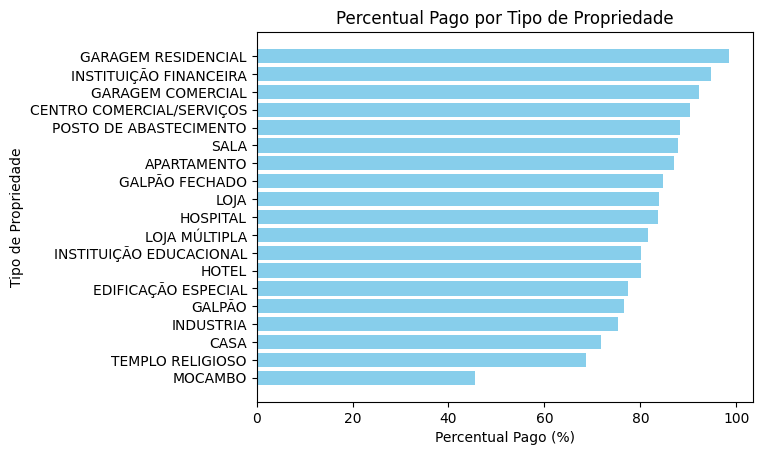

In [198]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
soma_tipo_propriedade = soma_tipo_propriedade.sort_values(by='percentual_pago_%', ascending=True)

ax.barh(soma_tipo_propriedade['tipo_propriedade'], soma_tipo_propriedade['percentual_pago_%'], color='skyblue')

ax.set_xlabel('Percentual Pago (%)')
ax.set_ylabel('Tipo de Propriedade')
ax.set_title('Percentual Pago por Tipo de Propriedade')

plt.show()


In [110]:
soma_tipo_propriedade.to_excel(r'C:\Users\Consultor\Documents\bases_pesquisa\bairro\tipo_propri.xlsx')

# Análise de pagamento por Bairro

In [172]:
df_bai = debitos_divida[debitos_divida['rpa'] == '6B']
soma_por_bairro = df_bai.groupby('bairro').agg({
    'dam': 'count',
    'regiao': 'max',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['vlr_total_dam'] - soma_por_bairro['vlr_pago']
soma_por_bairro['percentual_pago_%'] = (soma_por_bairro['vlr_pago'] / soma_por_bairro['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_bairro['vlr_total_dam'] = soma_por_bairro['vlr_total_dam'].apply(formatar_moeda)
soma_por_bairro['vlr_pago'] = soma_por_bairro['vlr_pago'].apply(formatar_moeda)
soma_por_bairro['vlr_aberto'] = soma_por_bairro['vlr_aberto'].apply(formatar_moeda)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['suposto_valor_devido'].apply(formatar_moeda)

soma_por_bairro = soma_por_bairro.sort_values(by='percentual_pago_%', ascending=False)
soma_por_bairro

,bairro,dam,regiao,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
1,IBURA,40283,SUL,"R$ 37.799.515,54","R$ 69.951.550,54","R$ 28.337.433,91","R$ 32.152.035,00",54.036709
2,JORDAO,12083,SUL,"R$ 5.918.826,77","R$ 13.073.310,08","R$ 5.029.421,75","R$ 7.154.483,31",45.274125
0,COHAB,16973,SUL,"R$ 7.743.911,49","R$ 33.789.518,97","R$ 7.521.302,02","R$ 26.045.607,48",22.918087


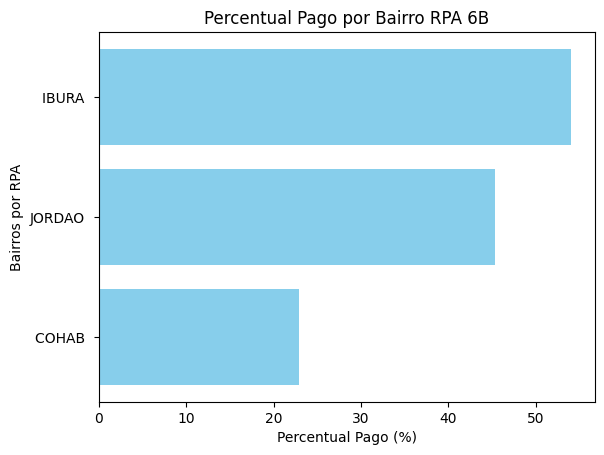

In [173]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
soma_por_bairro = soma_por_bairro.sort_values(by='percentual_pago_%', ascending=True)

ax.barh(soma_por_bairro['bairro'], soma_por_bairro['percentual_pago_%'], color='skyblue')

ax.set_xlabel('Percentual Pago (%)')
ax.set_ylabel('Bairros por RPA')
ax.set_title('Percentual Pago por Bairro RPA 6B')

plt.show()


In [68]:
df = soma_por_bairro[soma_por_bairro['bairro'].str.strip() == 'BRASILIA TEIMOSA'] # strip tira os espaços em branco
df

,bairro,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
16,BRASILIA TEIMOSA,8507,"R$ 4.319.569,56","R$ 7.373.771,81","R$ 2.623.094,44","R$ 3.054.202,25",58.58019


In [91]:
soma_por_bairro = debitos_divida.groupby('bairro').agg({
    'dam': 'count',
    'regiao': 'max',
    'rpa': 'max',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['vlr_total_dam'] - soma_por_bairro['vlr_pago']
soma_por_bairro['percentual_pago_%'] = (soma_por_bairro['vlr_pago'] / soma_por_bairro['vlr_total_dam']) * 100
soma_por_bairro['percentual_dams_%'] = (soma_por_bairro['dam'] / 2506527) *100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_bairro['vlr_total_dam'] = soma_por_bairro['vlr_total_dam'].apply(formatar_moeda)
soma_por_bairro['vlr_pago'] = soma_por_bairro['vlr_pago'].apply(formatar_moeda)
soma_por_bairro['vlr_aberto'] = soma_por_bairro['vlr_aberto'].apply(formatar_moeda)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['suposto_valor_devido'].apply(formatar_moeda)

soma_por_bairro = soma_por_bairro.sort_values(by='percentual_dams_%', ascending=False)
soma_por_bairro

,bairro,dam,regiao,rpa,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%,percentual_dams_%
12,BOA VIAGEM,497142,SUL,6,"R$ 1.375.638.547,62","R$ 1.596.834.707,14","R$ 204.128.339,87","R$ 221.196.159,52",86.147836,19.833898
49,IMBIRIBEIRA,97520,SUL,6,"R$ 278.190.007,18","R$ 344.233.835,42","R$ 62.979.193,78","R$ 66.043.828,24",80.814254,3.890642
13,BOA VISTA,96724,CENTRO,1,"R$ 212.843.269,87","R$ 257.095.205,06","R$ 39.595.970,47","R$ 44.251.935,19",82.787724,3.858885
91,VARZEA,96426,OESTE,4,"R$ 117.554.350,47","R$ 196.885.434,70","R$ 46.280.313,65","R$ 79.331.084,23",59.706982,3.846996
24,CASA AMARELA,90324,NORDESTE,3A,"R$ 156.241.369,40","R$ 191.507.518,44","R$ 29.592.545,14","R$ 35.266.149,04",81.584979,3.603552
...,...,...,...,...,...,...,...,...,...,...
6,ALTO SANTA TEREZINHA,1034,NORTE,2,"R$ 295.192,56","R$ 7.403.784,04","R$ 292.522,15","R$ 7.108.591,48",3.987050,0.041252
35,DOIS IRMAOS,656,NORDESTE,3A,"R$ 4.916.277,63","R$ 12.330.208,81","R$ 7.231.563,24","R$ 7.413.931,18",39.871812,0.026172
27,CIDADE UNIVERSITARIA,285,OESTE,4,"R$ 2.052.381,90","R$ 19.699.033,45","R$ 3.921.738,20","R$ 17.646.651,55",10.418693,0.011370
69,PEIXINHOS,147,NORTE,2,"R$ 248.872,60","R$ 472.026,51","R$ 112.561,08","R$ 223.153,91",52.724284,0.005865


In [93]:
soma_por_bairro.to_excel(r'C:\Users\Consultor\Documents\bases_pesquisa\bairro.xlsx')

In [71]:
soma_por_bairro = dams_não_pagas.groupby('bairro').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['vlr_total_dam'] - soma_por_bairro['vlr_pago']
soma_por_bairro['percentual_pago_%'] = (soma_por_bairro['vlr_pago'] / soma_por_bairro['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_bairro['vlr_total_dam'] = soma_por_bairro['vlr_total_dam'].apply(formatar_moeda)
soma_por_bairro['vlr_pago'] = soma_por_bairro['vlr_pago'].apply(formatar_moeda)
soma_por_bairro['vlr_aberto'] = soma_por_bairro['vlr_aberto'].apply(formatar_moeda)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['suposto_valor_devido'].apply(formatar_moeda)

soma_por_bairro = soma_por_bairro.sort_values(by='dam', ascending=False)
soma_por_bairro.head(10)

,bairro,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
12,BOA VIAGEM,35034,"R$ 0,00","R$ 143.712.693,80","R$ 138.230.961,91","R$ 143.712.693,80",0.0
91,VARZEA,21822,"R$ 0,00","R$ 71.999.841,60","R$ 40.000.996,81","R$ 71.999.841,60",0.0
49,IMBIRIBEIRA,15239,"R$ 0,00","R$ 48.075.993,92","R$ 47.676.440,65","R$ 48.075.993,92",0.0
45,IBURA,15088,"R$ 0,00","R$ 28.757.925,23","R$ 26.432.231,76","R$ 28.757.925,23",0.0
31,CORDEIRO,11294,"R$ 0,00","R$ 35.885.131,11","R$ 23.118.233,30","R$ 35.885.131,11",0.0
1,AFOGADOS,11236,"R$ 0,00","R$ 38.497.016,56","R$ 24.235.818,49","R$ 38.497.016,56",0.0
13,BOA VISTA,10732,"R$ 0,00","R$ 30.373.046,77","R$ 29.596.984,75","R$ 30.373.046,77",0.0
51,IPUTINGA,10650,"R$ 0,00","R$ 47.968.800,56","R$ 22.467.832,51","R$ 47.968.800,56",0.0
24,CASA AMARELA,9202,"R$ 0,00","R$ 25.658.165,40","R$ 21.421.831,52","R$ 25.658.165,40",0.0
53,JARDIM SAO PAULO,7867,"R$ 0,00","R$ 17.889.111,44","R$ 13.553.518,67","R$ 17.889.111,44",0.0


In [70]:
df = soma_por_bairro[soma_por_bairro['bairro'].str.strip() == 'BRASILIA TEIMOSA'] # strip tira os espaços em branco
df

,bairro,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
16,BRASILIA TEIMOSA,2343,"R$ 0,00","R$ 2.753.310,75","R$ 2.372.386,52","R$ 2.753.310,75",0.0


In [57]:
soma_por_bairro = dams_não_pagas.groupby('bairro').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['vlr_total_dam'] - soma_por_bairro['vlr_pago']
soma_por_bairro['percentual_pago_%'] = (soma_por_bairro['vlr_pago'] / soma_por_bairro['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_por_bairro = soma_por_bairro.sort_values(by='vlr_total_dam', ascending=False)
soma_por_bairro['vlr_total_dam'] = soma_por_bairro['vlr_total_dam'].apply(formatar_moeda)
soma_por_bairro['vlr_pago'] = soma_por_bairro['vlr_pago'].apply(formatar_moeda)
soma_por_bairro['vlr_aberto'] = soma_por_bairro['vlr_aberto'].apply(formatar_moeda)
soma_por_bairro['suposto_valor_devido'] = soma_por_bairro['suposto_valor_devido'].apply(formatar_moeda)


soma_por_bairro.head(10)

,bairro,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
12,BOA VIAGEM,35034,"R$ 0,00","R$ 143.712.693,80","R$ 138.230.961,91","R$ 143.712.693,80",0.0
91,VARZEA,21822,"R$ 0,00","R$ 71.999.841,60","R$ 40.000.996,81","R$ 71.999.841,60",0.0
49,IMBIRIBEIRA,15239,"R$ 0,00","R$ 48.075.993,92","R$ 47.676.440,65","R$ 48.075.993,92",0.0
51,IPUTINGA,10650,"R$ 0,00","R$ 47.968.800,56","R$ 22.467.832,51","R$ 47.968.800,56",0.0
1,AFOGADOS,11236,"R$ 0,00","R$ 38.497.016,56","R$ 24.235.818,49","R$ 38.497.016,56",0.0
31,CORDEIRO,11294,"R$ 0,00","R$ 35.885.131,11","R$ 23.118.233,30","R$ 35.885.131,11",0.0
70,PINA,7055,"R$ 0,00","R$ 31.836.070,82","R$ 24.952.486,68","R$ 31.836.070,82",0.0
13,BOA VISTA,10732,"R$ 0,00","R$ 30.373.046,77","R$ 29.596.984,75","R$ 30.373.046,77",0.0
45,IBURA,15088,"R$ 0,00","R$ 28.757.925,23","R$ 26.432.231,76","R$ 28.757.925,23",0.0
80,SANTO AMARO,7033,"R$ 0,00","R$ 27.264.610,98","R$ 26.337.866,83","R$ 27.264.610,98",0.0


---

# Análise de pagamento por edificação

In [111]:
soma_tipo_edificacao = debitos_divida.groupby('natureza_imovel').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_tipo_edificacao['suposto_valor_devido'] = soma_tipo_edificacao['vlr_total_dam'] - soma_tipo_edificacao['vlr_pago']
soma_tipo_edificacao['percentual_pago_%'] = (soma_tipo_edificacao['vlr_pago'] / soma_tipo_edificacao['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_tipo_edificacao['vlr_total_dam'] = soma_tipo_edificacao['vlr_total_dam'].apply(formatar_moeda)
soma_tipo_edificacao['vlr_pago'] = soma_tipo_edificacao['vlr_pago'].apply(formatar_moeda)
soma_tipo_edificacao['vlr_aberto'] = soma_tipo_edificacao['vlr_aberto'].apply(formatar_moeda)
soma_tipo_edificacao['suposto_valor_devido'] = soma_tipo_edificacao['suposto_valor_devido'].apply(formatar_moeda)

soma_tipo_edificacao = soma_tipo_edificacao.sort_values(by='percentual_pago_%', ascending=False)
soma_tipo_edificacao

,natureza_imovel,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
0,P,2398527,"R$ 5.314.436.357,69","R$ 6.422.162.474,92","R$ 1.001.145.670,64","R$ 1.107.726.117,23",82.751509
1,T,108000,"R$ 102.573.358,71","R$ 567.916.770,94","R$ 167.896.466,83","R$ 465.343.412,23",18.061336


In [114]:
soma_tipo_edificacao.to_excel(r'C:\Users\Consultor\Documents\bases_pesquisa\bairro\edificacao.xlsx')

# análise por quantidade de pavimentos

In [34]:
df_apto = debitos_divida[debitos_divida['tipo_propriedade'].str.strip() == 'CASA']
# df_apto = debitos_divida[debitos_divida['qtd_pavimentos'] == 38]
df_apto


,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,vlr_pago,vlr_aberto,vlr_total_dam,regiao,rpa
2,d9c9e39c4c4f8ce3,5f6ad6b7a75ce14211babe4a46e18b6d,b340af53f72ff1fdcd124eb8021f7dca,2018.0,1,89.00,1,P,CASA,CONSTRUÍDA,AFOGADOS,2008-12-11 19:54:22,691.70,0.00,691.70,SUDESTE,5
5,6503bfb9ebc00b58,a1bb4e4d67edf0e711babe4a46e18b6d,NaN,2018.0,1,349.37,1,P,CASA,CONSTRUÍDA,VARZEA,2008-12-11 19:32:57,4094.60,0.00,4094.60,OESTE,4
7,80d6391b01890bd1,78546ddc95d5a970875350beaddc7871,17c8b0a9f3f213150246e2b93c1bf25c,2022.0,2,445.24,1,P,CASA,CONSTRUÍDA,PRADO,2008-12-11 22:44:12,618.02,3566.12,4184.14,OESTE,4
8,1104680ccd4612da,a493ca5ae4cc1c23875350beaddc7871,c0a70d3ce84f401d1603ecd7ff6be21f,2022.0,1,58.20,0,P,CASA,CONSTRUÍDA,VARZEA,2013-04-08 10:18:52,0.00,437.22,437.22,OESTE,4
9,410e56039192f2a8,4324dce432ff10d6875350beaddc7871,80cc460b492e1374be91dcec7d89e48e,2022.0,1,102.69,1,P,CASA,CONSTRUÍDA,SAN MARTIN,2008-12-11 22:47:04,1119.30,0.00,1119.30,SUDESTE,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506479,265155c7fe946608,e52aaf5972feb5b8875350beaddc7871,b54e0f860ca9aa31344d77602867ec09,2022.0,1,324.99,1,P,CASA,CONSTRUÍDA,AREIAS,2008-12-11 22:51:37,0.00,9773.08,9773.08,SUDESTE,5
2506490,3e20336a2e1b37ef,5789e043e562f61d4c1f696350fff79e,86695f7fe3b3c0a7d8b209292c0ce31d,2019.0,1,78.50,1,P,CASA,CONSTRUÍDA,SAN MARTIN,2008-12-11 22:46:39,564.40,0.00,564.40,SUDESTE,5
2506498,2c860726b83b303e,a859726e8dc4faaa90ecf5aaf6be6eb7,b6de86f22cb164381603ecd7ff6be21f,2023.0,1,125.00,1,P,CASA,CONSTRUÍDA,TEJIPIO,2008-12-11 20:28:07,0.00,1486.09,1486.09,SUDESTE,5
2506513,8b9584f0d83bf214,f3e37572c06add56e08920064611a7cf,95c52ae9e9dbd1bf344d77602867ec09,2017.0,1,54.00,1,P,CASA,CONSTRUÍDA,TORROES,2008-12-11 18:58:53,790.67,0.00,790.67,OESTE,4


In [35]:
soma_qtd_pavimentos = df_apto.groupby('qtd_pavimentos').agg({
    'dam': 'count',
    'vlr_pago': 'sum',
    'vlr_total_dam': 'sum',
    'vlr_aberto': 'sum'
}).reset_index()

soma_qtd_pavimentos['suposto_valor_devido'] = soma_qtd_pavimentos['vlr_total_dam'] - soma_qtd_pavimentos['vlr_pago']
soma_qtd_pavimentos['percentual_pago_%'] = (soma_qtd_pavimentos['vlr_pago'] / soma_qtd_pavimentos['vlr_total_dam']) * 100
# soma_por_ano['diferenca_devido_aberto'] = soma_por_ano['suposto_valor_devido'] - soma_por_ano['vlr_aberto']

soma_qtd_pavimentos['vlr_total_dam'] = soma_qtd_pavimentos['vlr_total_dam'].apply(formatar_moeda)
soma_qtd_pavimentos['vlr_pago'] = soma_qtd_pavimentos['vlr_pago'].apply(formatar_moeda)
soma_qtd_pavimentos['vlr_aberto'] = soma_qtd_pavimentos['vlr_aberto'].apply(formatar_moeda)
soma_qtd_pavimentos['suposto_valor_devido'] = soma_qtd_pavimentos['suposto_valor_devido'].apply(formatar_moeda)

soma_qtd_pavimentos = soma_qtd_pavimentos.sort_values(by='qtd_pavimentos', ascending=True)
soma_qtd_pavimentos

,qtd_pavimentos,dam,vlr_pago,vlr_total_dam,vlr_aberto,suposto_valor_devido,percentual_pago_%
0,0,16,"R$ 4.521,56","R$ 6.437,14","R$ 1.915,58","R$ 1.915,58",70.241753
1,1,517832,"R$ 527.039.205,68","R$ 750.150.133,81","R$ 187.438.531,38","R$ 223.110.928,13",70.257830
2,2,121752,"R$ 275.698.211,96","R$ 365.961.632,01","R$ 85.093.001,99","R$ 90.263.420,05",75.335278
3,3,6546,"R$ 16.387.833,08","R$ 23.586.194,72","R$ 6.957.476,56","R$ 7.198.361,64",69.480615
4,4,647,"R$ 1.703.221,23","R$ 2.421.724,68","R$ 695.634,11","R$ 718.503,45",70.330919
5,5,259,"R$ 484.403,78","R$ 614.900,62","R$ 118.550,42","R$ 130.496,84",78.777572
6,6,84,"R$ 375.171,73","R$ 402.416,60","R$ 26.230,06","R$ 27.244,87",93.229685
7,7,88,"R$ 54.394,77","R$ 78.426,56","R$ 22.940,31","R$ 24.031,79",69.357588
8,8,50,"R$ 80.012,63","R$ 95.659,44","R$ 15.518,25","R$ 15.646,81",83.643214
9,9,43,"R$ 20.214,46","R$ 27.252,67","R$ 6.924,57","R$ 7.038,21",74.174237


In [32]:
soma_qtd_pavimentos['qtd_pavimentos'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 23, 27, 31, 34, 41, 60, 75], dtype=int64)

<Axes: >

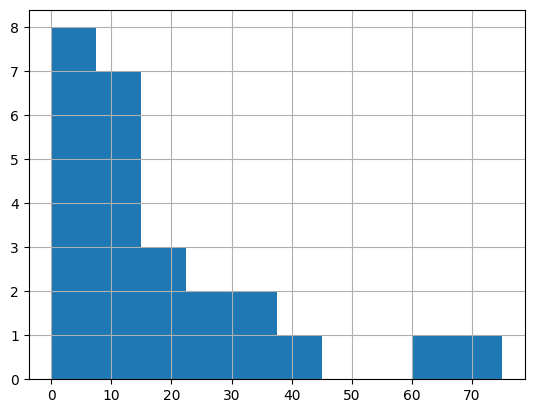

In [33]:
soma_qtd_pavimentos['qtd_pavimentos'].hist()

# CONTRIBUINTE

In [94]:
tbl_contribuinte = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_contribuinte_db_2.csv'
contribuinte = pd.read_csv(tbl_contribuinte)
contribuinte

,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais
0,00001a3e5b2177499daa7b7dbb545c1c,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
1,00003a695da4777aec557718ffae83ea,NaN,NaN,NaN,NaN,1,NaN,NaN,8.0
2,000046c85d18a6f7968646cfc1e328f2,NaN,NaN,NaN,NaN,1,1.0,NaN,8.0
3,0000b23be5378f1b8e79cf1867e8cc19,NaN,NaN,1.0,1.0,4,4.0,NaN,32.0
4,00014b72ca2a255bd4613fe022d53698,1.0,NaN,NaN,5.0,2,1.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
250260,ffff0e3e56845cdf1603ecd7ff6be21f,1.0,1.0,2.0,1.0,1,NaN,2.0,7.0
250261,ffff3836dbf935321bc34267b5521a39,NaN,NaN,NaN,2.0,1,NaN,NaN,8.0
250262,ffff63826b501d84d8b209292c0ce31d,1.0,NaN,NaN,NaN,2,NaN,1.0,8.0
250263,ffffc6563e67d8b38e79cf1867e8cc19,NaN,NaN,NaN,3.0,3,2.0,NaN,14.0


In [95]:
contagem_nulos_por_coluna_contribuinte = contribuinte.isnull().sum()
total_registros_contribuinte = len(contribuinte)

porcentagem_nulos = (contagem_nulos_por_coluna_contribuinte / total_registros_contribuinte) * 100

resultado = pd.DataFrame({
    'Contagem Nulos': contagem_nulos_por_coluna_contribuinte,
    'Total Registros': total_registros_contribuinte,
    'Porcentagem Nulos (%)': porcentagem_nulos
})

resultado

,Contagem Nulos,Total Registros,Porcentagem Nulos (%)
id_contribuinte,0,250265,0.000000
reco_debito,107813,250265,43.079536
reco_divida_ativa,136310,250265,54.466266
freq_parcelamento,199736,250265,79.809802
hist_pagamento_qtd,95799,250265,38.279024
num_imoveis,0,250265,0.000000
pgt_cota_unica,184845,250265,73.859709
hist_aberto_qtd,97724,250265,39.048209
hist_dams_totais,29777,250265,11.898188
